Loads cocoa flavor and climate datasets.

Cleans column names and standardizes formats.

Renames columns to align ("Bean Origin" → "Country", etc.).

Converts year columns to numeric.

Merges datasets on ["Country", "Year"] (left join).

Drops irrelevant columns (e.g., "Flag", "Company").

Encodes categorical variables using numeric codes.

Fills missing values using group-based forward/backward fill + column medians.

Plots feature correlations with cocoa quality rating using a heatmap.

In [5]:
import pandas as pd
import numpy as np

# Step 1: Load datasets
flavor_df = pd.read_csv("full_flavors_of_cocoa_cleaned-2.csv")
climate_df = pd.read_csv("Climate_dataset.csv")

# Step 2: Standardize column names
flavor_df.columns = flavor_df.columns.str.strip()
climate_df.columns = climate_df.columns.str.strip()

# Step 3: Rename columns for consistency
flavor_df = flavor_df.rename(columns={
    "Bean Origin": "Country",
    "Review Date": "Year"
})
climate_df = climate_df.rename(columns={"Country ": "Country"})

# Step 4: Convert Year to numeric
flavor_df["Year"] = pd.to_numeric(flavor_df["Year"], errors="coerce")
climate_df["Year"] = pd.to_numeric(climate_df["Year"], errors="coerce")

# Step 5: Merge flavor + climate datasets
merged = pd.merge(flavor_df, climate_df, on=["Country", "Year"], how="left")

# Step 6: Drop irrelevant or noisy columns
drop_cols = [
    "Flag", "Flag Description", "Unnamed: 10", "Id", "Company"
]
merged = merged.drop(columns=[col for col in drop_cols if col in merged.columns])

# Step 7: Encode object/categorical columns
for col in merged.select_dtypes(include="object").columns:
    merged[col] = merged[col].astype("category").cat.codes.replace({-1: np.nan})

# Step 8: Fill missing values
merged = merged.sort_values(by=["Country", "Year"])
merged = merged.groupby("Country").ffill().bfill()

# Final NaN fill with column-wise median
for col in merged.columns:
    if merged[col].isnull().sum() > 0:
        merged[col] = merged[col].fillna(merged[col].median())

# Step 9: Save final dataset
merged.to_csv("final_quality_dataset.csv", index=False)
print(" Merged dataset saved as 'final_quality_dataset.csv'")
print("Final shape:", merged.shape)

# Step 10: Optional — Visualize correlation with quality
import seaborn as sns
import matplotlib.pyplot as plt

corr = merged.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr[["Rating (Out of 10)"]].sort_values(by="Rating (Out of 10)", ascending=False), annot=True, cmap="coolwarm")
plt.title("Correlation with Cocoa Quality Rating")
plt.show()


 Merged dataset saved as 'final_quality_dataset.csv'
Final shape: (1791, 11)


Trains a Conditional GAN to generate synthetic cocoa quality data based on Company Location. It normalizes real data, builds and trains a GAN, generates 3000 fake samples, assigns quality ratings from real data, and saves the output as synthetic_quality_data_condgan.csv.

In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load dataset
df = pd.read_csv("final_quality_dataset.csv")
condition_col = "Company Location"
target_col = "Rating (Out of 10)"

# Step 2: Prepare condition + features
condition = df[condition_col]
X = df.drop(columns=[target_col])
y = df[target_col]

n_classes = int(condition.nunique())
condition_input = condition.values.reshape(-1, 1).astype(np.float32)

# Step 3: Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Convert to tensors
X_tensor = tf.convert_to_tensor(X_scaled, dtype=tf.float32)
cond_tensor = tf.convert_to_tensor(condition_input, dtype=tf.float32)

# Step 5: Create batched dataset
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((X_tensor, cond_tensor))
dataset = dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Step 6: GAN Settings
latent_dim = 32
input_dim = X_scaled.shape[1]
epochs = 3000

# Step 7: Build Generator
def build_generator():
    noise_input = layers.Input(shape=(latent_dim,))
    cond_input = layers.Input(shape=(1,))
    x = layers.Concatenate()([noise_input, cond_input])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    output = layers.Dense(input_dim, activation='sigmoid')(x)
    return tf.keras.Model([noise_input, cond_input], output)

# Step 8: Build Discriminator
def build_discriminator():
    data_input = layers.Input(shape=(input_dim,))
    cond_input = layers.Input(shape=(1,))
    x = layers.Concatenate()([data_input, cond_input])
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model([data_input, cond_input], output)

# Step 9: Instantiate models and losses
generator = build_generator()
discriminator = build_discriminator()
loss_fn = tf.keras.losses.BinaryCrossentropy()
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

# Step 10: Training Step
@tf.function
def train_step(real_data, real_cond):
    batch_size = tf.shape(real_data)[0]
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_data = generator([noise, real_cond], training=True)
        real_output = discriminator([real_data, real_cond], training=True)
        fake_output = discriminator([fake_data, real_cond], training=True)

        d_loss_real = loss_fn(tf.ones_like(real_output), real_output)
        d_loss_fake = loss_fn(tf.zeros_like(fake_output), fake_output)
        d_loss = d_loss_real + d_loss_fake

        g_loss = loss_fn(tf.ones_like(fake_output), fake_output)

    grads_g = g_tape.gradient(g_loss, generator.trainable_variables)
    grads_d = d_tape.gradient(d_loss, discriminator.trainable_variables)
    gen_opt.apply_gradients(zip(grads_g, generator.trainable_variables))
    disc_opt.apply_gradients(zip(grads_d, discriminator.trainable_variables))
    return g_loss, d_loss

# Step 11: Train GAN
for epoch in range(epochs):
    for real_data, real_cond in dataset:
        g_loss, d_loss = train_step(real_data, real_cond)
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Generator Loss: {g_loss:.4f} | Discriminator Loss: {d_loss:.4f}")

# Step 12: Generate Synthetic Data
num_samples = 3000
random_noise = tf.random.normal([num_samples, latent_dim])
random_cond = tf.convert_to_tensor(
    np.random.randint(0, n_classes, size=(num_samples, 1)), dtype=tf.float32
)
synthetic_scaled = generator([random_noise, random_cond], training=False).numpy()
synthetic_data = scaler.inverse_transform(synthetic_scaled)

# Step 13: Build final synthetic DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=X.columns)
synthetic_df[condition_col] = random_cond.numpy().astype(int)

# Assign quality ratings (optional): sample from real distribution
synthetic_df[target_col] = y.sample(n=num_samples, replace=True).reset_index(drop=True)

# Step 14: Save to CSV
synthetic_df.to_csv("synthetic_quality_data_condgan.csv", index=False)
print("✅ Synthetic quality dataset saved as 'synthetic_quality_data_condgan.csv'")


Epoch 0 | Generator Loss: 0.6966 | Discriminator Loss: 1.4685
Epoch 500 | Generator Loss: 0.6214 | Discriminator Loss: 1.5962
Epoch 1000 | Generator Loss: 0.6438 | Discriminator Loss: 1.3971
Epoch 1500 | Generator Loss: 0.6959 | Discriminator Loss: 1.4718
Epoch 2000 | Generator Loss: 0.4509 | Discriminator Loss: 2.0276
Epoch 2500 | Generator Loss: 0.5407 | Discriminator Loss: 1.6415
✅ Synthetic quality dataset saved as 'synthetic_quality_data_condgan.csv'


Model Name:- TabNetRegressor

Input Parameters:

Company Location – dropdown (e.g., Peru → encoded as 8)

Broad Bean Origin – dropdown (e.g., Ecuador → 5)

Bean Type – dropdown (e.g., Forastero → 1)

Cocoa Percent – numeric (e.g., 70)

Year – numeric (e.g., 2021)

Temperature Change (°C) – numeric (e.g., 1.25)

Annual Precipitation – numeric (e.g., 1800)



In [5]:
# Step 1: Install TabNet
!pip install pytorch-tabnet --quiet

# Step 2: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# Step 3: Load datasets
real_df = pd.read_csv("final_quality_dataset.csv")
synthetic_df = pd.read_csv("synthetic_quality_data_condgan.csv")

# Step 4: Combine datasets
df = pd.concat([real_df, synthetic_df], ignore_index=True)
target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 5: Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Prepare real test set for evaluation
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# Step 7: Build TabNet model
tabnet = TabNetRegressor(
    n_d=64,
    n_a=64,
    n_steps=7,
    gamma=1.3,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    mask_type='entmax',
    seed=42,
    verbose=1
)

# Step 8: Train TabNet on full dataset
tabnet.fit(
    X_train=X_scaled, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test, y_test.values.reshape(-1, 1))],
    eval_name=["val"],
    eval_metric=["mae"],
    max_epochs=300,
    patience=30,
    batch_size=256,
    virtual_batch_size=64
)

# Step 9: Evaluate on real test data
y_pred = tabnet.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_score_10pt = 10 * (1 - min(mae / 10, 1))

# Step 10: Print results
print("\n Evaluation on Real Test Data (TabNet + Synthetic Quality Data):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 9.11158 | val_mae: 0.98327 |  0:00:02s
epoch 1  | loss: 2.39688 | val_mae: 1.08969 |  0:00:04s
epoch 2  | loss: 1.78904 | val_mae: 0.89714 |  0:00:06s
epoch 3  | loss: 1.48612 | val_mae: 0.8435  |  0:00:08s
epoch 4  | loss: 1.42554 | val_mae: 0.90673 |  0:00:10s
epoch 5  | loss: 1.39536 | val_mae: 0.92781 |  0:00:12s
epoch 6  | loss: 1.36951 | val_mae: 0.85122 |  0:00:14s
epoch 7  | loss: 1.31517 | val_mae: 0.89504 |  0:00:16s
epoch 8  | loss: 1.30409 | val_mae: 0.91223 |  0:00:18s
epoch 9  | loss: 1.27634 | val_mae: 0.84596 |  0:00:20s
epoch 10 | loss: 1.27902 | val_mae: 0.92338 |  0:00:23s
epoch 11 | loss: 1.36224 | val_mae: 0.98153 |  0:00:25s
epoch 12 | loss: 1.29306 | val_mae: 0.87066 |  0:00:27s
epoch 13 | loss: 1.22621 | val_mae: 0.88472 |  0:00:29s
epoch 14 | loss: 1.24768 | val_mae: 0.8684  |  0:00:31s
epoch 15 | loss: 1.24532 | val_mae: 0.86397 |  0:00:33s
epoch 16 | loss: 1.23984 | val_mae: 0.88895 |  0:00:35s
epoch 17 | loss: 1.2072  | val_mae: 0.90825 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



 Evaluation on Real Test Data (TabNet + Synthetic Quality Data):
R² Score: 0.1048
MAE: 0.78
MAE Score (out of 10): 9.22


Model: XGBRegressor

Input Parameters for UI:

Company Location – dropdown
(e.g., Peru → encoded as 8)

Broad Bean Origin – dropdown
(e.g., Ecuador → encoded as 5)

Bean Type – dropdown
(e.g., Forastero → encoded as 1)

Cocoa Percent – numeric input
(e.g., 70)

Year – numeric input
(e.g., 2021)

Temperature Change (°C) – numeric input
(e.g., 1.25)

Annual Precipitation – numeric input
(e.g., 1800)





In [6]:
# Step 1: Install XGBoost
!pip install xgboost --quiet
# Step 2: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

# Step 3: Load real + synthetic data
real_df = pd.read_csv("final_quality_dataset.csv")
synthetic_df = pd.read_csv("synthetic_quality_data_condgan.csv")

# Step 4: Combine datasets
df = pd.concat([real_df, synthetic_df], ignore_index=True)
target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 5: Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Prepare real test set
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# Step 6: Train XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_scaled, y.values)

# Step 7: Evaluate on real data
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_score_10pt = 10 * (1 - min(mae / 10, 1))

# Step 8: Results
print("\n✅ Evaluation on Real Test Data (XGBoost + Synthetic Quality Data):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")



✅ Evaluation on Real Test Data (XGBoost + Synthetic Quality Data):
R² Score: 0.5276
MAE: 0.59
MAE Score (out of 10): 9.41


Model: Simple TabNetRegressor.

Input Parameters for UI (with examples):

Company Location – dropdown
Example: "Peru" → encoded as 8

Broad Bean Origin – dropdown
Example: "Ecuador" → encoded as 5

Bean Type – dropdown
Example: "Forastero" → encoded as 1

Cocoa Percent – numeric input
Example: 70

Year – numeric input
Example: 2021

Temperature Change (°C) – numeric input
Example: 1.25

Annual Precipitation – numeric input
Example: 1800



In [7]:
# Step 1: Install TabNet
!pip install pytorch-tabnet --quiet
# Step 2: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# Step 3: Load datasets (real + synthetic)
real_df = pd.read_csv("final_quality_dataset.csv")
synthetic_df = pd.read_csv("synthetic_quality_data_condgan.csv")

# Step 4: Combine both datasets
df = pd.concat([real_df, synthetic_df], ignore_index=True)
target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 5: Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Prepare real data for test evaluation
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# Step 6: Define and train simple TabNet model
tabnet = TabNetRegressor(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    seed=42,
    verbose=1
)

tabnet.fit(
    X_train=X_scaled, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test, y_test.values.reshape(-1, 1))],
    eval_name=["val"],
    eval_metric=["mae"],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=64
)

# Step 7: Evaluate on real test data
y_pred = tabnet.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_score_10pt = 10 * (1 - min(mae / 10, 1))  # MAE score on 10-point scale

# Step 8: Print results
print("\n✅ Evaluation on Real Test Data (Simple TabNet Regressor):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8.54205 | val_mae: 1.92168 |  0:00:00s
epoch 1  | loss: 1.41194 | val_mae: 0.90885 |  0:00:01s
epoch 2  | loss: 1.37665 | val_mae: 0.8853  |  0:00:01s
epoch 3  | loss: 1.28762 | val_mae: 0.90565 |  0:00:02s
epoch 4  | loss: 1.26784 | val_mae: 0.8637  |  0:00:02s
epoch 5  | loss: 1.25333 | val_mae: 0.84302 |  0:00:03s
epoch 6  | loss: 1.24793 | val_mae: 0.87905 |  0:00:03s
epoch 7  | loss: 1.26631 | val_mae: 0.88401 |  0:00:04s
epoch 8  | loss: 1.22383 | val_mae: 0.86699 |  0:00:04s
epoch 9  | loss: 1.22375 | val_mae: 0.85541 |  0:00:05s
epoch 10 | loss: 1.22718 | val_mae: 0.88305 |  0:00:05s
epoch 11 | loss: 1.25459 | val_mae: 0.86733 |  0:00:06s
epoch 12 | loss: 1.22317 | val_mae: 0.85428 |  0:00:06s
epoch 13 | loss: 1.20157 | val_mae: 0.8506  |  0:00:07s
epoch 14 | loss: 1.19257 | val_mae: 0.86755 |  0:00:08s
epoch 15 | loss: 1.21272 | val_mae: 0.85491 |  0:00:09s
epoch 16 | loss: 1.18697 | val_mae: 0.83639 |  0:00:09s
epoch 17 | loss: 1.19042 | val_mae: 0.84202 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



✅ Evaluation on Real Test Data (Simple TabNet Regressor):
R² Score: 0.0899
MAE: 0.81
MAE Score (out of 10): 9.19


Model: Advanced TabNetRegressor + Entmax

Input Parameters for UI:

Company Location – dropdown (e.g., Peru → 8)

Broad Bean Origin – dropdown (e.g., Ecuador → 5)

Bean Type – dropdown (e.g., Forastero → 1)

Cocoa Percent – numeric (e.g., 70)

Year – numeric (e.g., 2021)

Temperature Change (°C) – numeric (e.g., 1.25)

Annual Precipitation – numeric (e.g., 1800)

In [8]:
# Step 1: Install TabNet
!pip install pytorch-tabnet --quiet
# Step 2: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# Step 3: Load data (real + synthetic)
real_df = pd.read_csv("final_quality_dataset.csv")
synthetic_df = pd.read_csv("synthetic_quality_data_condgan.csv")

# Step 4: Combine datasets
df = pd.concat([real_df, synthetic_df], ignore_index=True)
target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 5: Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# Step 6: Build advanced TabNet model
tabnet = TabNetRegressor(
    n_d=64,                      # decision layer width
    n_a=64,                      # attention layer width
    n_steps=7,                   # number of decision steps
    gamma=1.3,                   # relaxation factor
    lambda_sparse=1e-4,          # sparsity regularization
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    mask_type='entmax',          # attention type
    seed=42,
    verbose=1
)

# Step 7: Train model
tabnet.fit(
    X_train=X_scaled, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test, y_test.values.reshape(-1, 1))],
    eval_name=["val"],
    eval_metric=["mae"],
    max_epochs=300,
    patience=30,
    batch_size=256,
    virtual_batch_size=64
)

# Step 8: Evaluate
y_pred = tabnet.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_score_10pt = 10 * (1 - min(mae / 10, 1))

# Step 9: Print results
print("\n✅ Evaluation on Real Test Data (Advanced TabNet + Entmax):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")



/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 9.11158 | val_mae: 0.98327 |  0:00:01s
epoch 1  | loss: 2.39688 | val_mae: 1.08969 |  0:00:03s
epoch 2  | loss: 1.78904 | val_mae: 0.89714 |  0:00:06s
epoch 3  | loss: 1.48612 | val_mae: 0.8435  |  0:00:08s
epoch 4  | loss: 1.42554 | val_mae: 0.90673 |  0:00:10s
epoch 5  | loss: 1.39536 | val_mae: 0.92781 |  0:00:12s
epoch 6  | loss: 1.36951 | val_mae: 0.85122 |  0:00:14s
epoch 7  | loss: 1.31517 | val_mae: 0.89504 |  0:00:16s
epoch 8  | loss: 1.30409 | val_mae: 0.91223 |  0:00:19s
epoch 9  | loss: 1.27634 | val_mae: 0.84596 |  0:00:21s
epoch 10 | loss: 1.27902 | val_mae: 0.92338 |  0:00:23s
epoch 11 | loss: 1.36224 | val_mae: 0.98153 |  0:00:25s
epoch 12 | loss: 1.29306 | val_mae: 0.87066 |  0:00:27s
epoch 13 | loss: 1.22621 | val_mae: 0.88472 |  0:00:29s
epoch 14 | loss: 1.24768 | val_mae: 0.8684  |  0:00:31s
epoch 15 | loss: 1.24532 | val_mae: 0.86397 |  0:00:33s
epoch 16 | loss: 1.23984 | val_mae: 0.88895 |  0:00:35s
epoch 17 | loss: 1.2072  | val_mae: 0.90825 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



✅ Evaluation on Real Test Data (Advanced TabNet + Entmax):
R² Score: 0.1048
MAE: 0.78
MAE Score (out of 10): 9.22


In [10]:
!pip install optuna --quiet

Model: Optuna-Tuned TabNetRegressor

Input Parameters for UI:

Company Location – dropdown (e.g., Peru → 8)

Broad Bean Origin – dropdown (e.g., Ecuador → 5)

Bean Type – dropdown (e.g., Forastero → 1)

Cocoa Percent – numeric (e.g., 70)

Year – numeric (e.g., 2021)

Temperature Change (°C) – numeric (e.g., 1.25)

Annual Precipitation – numeric (e.g., 1800)












In [14]:

import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# Step 1: Load real + synthetic quality dataset
real_df = pd.read_csv("/content/final_quality_dataset.csv")
synthetic_df = pd.read_csv("/content/synthetic_quality_data_condgan.csv")
df = pd.concat([real_df, synthetic_df], ignore_index=True)

# Step 2: Features and target
target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 3: Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Use only real data for test set
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# Step 4: Define Optuna objective
def objective(trial):
    params = {
        "n_d": trial.suggest_int("n_d", 32, 128),
        "n_a": trial.suggest_int("n_a", 32, 128),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True),
        "optimizer_fn": torch.optim.Adam,
        "optimizer_params": {"lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True)},
        "mask_type": trial.suggest_categorical("mask_type", ["sparsemax", "entmax"]),
        "seed": 42,
        "verbose": 0
    }

    model = TabNetRegressor(**params)
    model.fit(
        X_train=X_scaled, y_train=y.values.reshape(-1, 1),
        eval_set=[(X_test, y_test.values.reshape(-1, 1))],
        eval_metric=["mae"],
        max_epochs=200,
        patience=20,
        batch_size=256,
        virtual_batch_size=64
    )

    y_pred = model.predict(X_test).flatten()
    return mean_absolute_error(y_test, y_pred)

# Step 5: Optimize
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Step 6: Train final model
best_params = study.best_params
final_model = TabNetRegressor(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={"lr": best_params["lr"]},
    mask_type=best_params["mask_type"],
    seed=42,
    verbose=1
)

final_model.fit(
    X_train=X_scaled, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test, y_test.values.reshape(-1, 1))],
    eval_metric=["mae"],
    max_epochs=200,
    patience=30,
    batch_size=256,
    virtual_batch_size=64
)

# Step 7: Evaluate R² and MAE
y_pred = final_model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_score_10pt = 10 * (1 - min(mae / 10, 1))

print("\n Evaluation on Real Test Data (Optuna-Tuned TabNet for Quality):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")
print("Best Hyperparameters:", best_params)


[I 2025-05-03 02:20:44,563] A new study created in memory with name: no-name-024e7826-67b0-431c-aa61-7951de1c5cdc



Early stopping occurred at epoch 99 with best_epoch = 79 and best_val_0_mae = 0.83172


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:24:50,623] Trial 0 finished with value: 0.8317170920146209 and parameters: {'n_d': 44, 'n_a': 119, 'n_steps': 6, 'gamma': 1.812610310734477, 'lambda_sparse': 2.834187229920073e-05, 'lr': 0.00014189758643008807, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.8317170920146209.



Early stopping occurred at epoch 58 with best_epoch = 38 and best_val_0_mae = 0.8667


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:27:33,258] Trial 1 finished with value: 0.8667006094143583 and parameters: {'n_d': 35, 'n_a': 126, 'n_steps': 7, 'gamma': 1.7263667045983517, 'lambda_sparse': 3.9630510689779526e-05, 'lr': 0.0006608005433753484, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.8317170920146209.



Early stopping occurred at epoch 67 with best_epoch = 47 and best_val_0_mae = 0.81173


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:31:34,893] Trial 2 finished with value: 0.8117260268803759 and parameters: {'n_d': 73, 'n_a': 99, 'n_steps': 9, 'gamma': 1.5145022318116705, 'lambda_sparse': 0.000787858271853965, 'lr': 0.008335677695178035, 'mask_type': 'sparsemax'}. Best is trial 2 with value: 0.8117260268803759.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_val_0_mae = 0.76686


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:33:45,811] Trial 3 finished with value: 0.7668646829706048 and parameters: {'n_d': 109, 'n_a': 122, 'n_steps': 3, 'gamma': 1.0087901817524503, 'lambda_sparse': 8.926104553310094e-06, 'lr': 0.0001919209093814037, 'mask_type': 'entmax'}. Best is trial 3 with value: 0.7668646829706048.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_val_0_mae = 0.82728


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:35:01,346] Trial 4 finished with value: 0.827284045206139 and parameters: {'n_d': 60, 'n_a': 116, 'n_steps': 3, 'gamma': 1.2577631179353832, 'lambda_sparse': 6.3721663217839754e-06, 'lr': 0.0002573225373143419, 'mask_type': 'sparsemax'}. Best is trial 3 with value: 0.7668646829706048.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_val_0_mae = 0.85015


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:36:34,227] Trial 5 finished with value: 0.8501459615808343 and parameters: {'n_d': 73, 'n_a': 68, 'n_steps': 8, 'gamma': 1.126163982260026, 'lambda_sparse': 0.0001130686560079294, 'lr': 0.0021950342613878903, 'mask_type': 'sparsemax'}. Best is trial 3 with value: 0.7668646829706048.



Early stopping occurred at epoch 77 with best_epoch = 57 and best_val_0_mae = 0.81174


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:39:24,171] Trial 6 finished with value: 0.8117411448762941 and parameters: {'n_d': 103, 'n_a': 66, 'n_steps': 5, 'gamma': 1.6892317567725024, 'lambda_sparse': 2.6620294820566522e-05, 'lr': 0.0005293403758153739, 'mask_type': 'entmax'}. Best is trial 3 with value: 0.7668646829706048.



Early stopping occurred at epoch 29 with best_epoch = 9 and best_val_0_mae = 0.86681


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:41:12,448] Trial 7 finished with value: 0.8668101252287543 and parameters: {'n_d': 112, 'n_a': 84, 'n_steps': 8, 'gamma': 1.35190186874532, 'lambda_sparse': 0.00014138886996688913, 'lr': 0.0011110574634802676, 'mask_type': 'sparsemax'}. Best is trial 3 with value: 0.7668646829706048.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_val_0_mae = 0.84166


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:42:26,499] Trial 8 finished with value: 0.8416645467115312 and parameters: {'n_d': 55, 'n_a': 78, 'n_steps': 5, 'gamma': 1.6530253006668723, 'lambda_sparse': 0.00039776246996411495, 'lr': 0.00087688134567792, 'mask_type': 'entmax'}. Best is trial 3 with value: 0.7668646829706048.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_val_0_mae = 0.86466


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:44:06,281] Trial 9 finished with value: 0.8646604569841561 and parameters: {'n_d': 116, 'n_a': 49, 'n_steps': 5, 'gamma': 1.9136414907913526, 'lambda_sparse': 0.0006762198725660121, 'lr': 0.0002301246739909735, 'mask_type': 'entmax'}. Best is trial 3 with value: 0.7668646829706048.



Early stopping occurred at epoch 108 with best_epoch = 88 and best_val_0_mae = 0.76069


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:47:10,286] Trial 10 finished with value: 0.7606885844950556 and parameters: {'n_d': 93, 'n_a': 102, 'n_steps': 3, 'gamma': 1.0320600548054817, 'lambda_sparse': 1.041653400772862e-06, 'lr': 0.00011321572216501955, 'mask_type': 'entmax'}. Best is trial 10 with value: 0.7606885844950556.



Early stopping occurred at epoch 143 with best_epoch = 123 and best_val_0_mae = 0.75062


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:51:05,700] Trial 11 finished with value: 0.7506246626543135 and parameters: {'n_d': 92, 'n_a': 101, 'n_steps': 3, 'gamma': 1.0205710112670952, 'lambda_sparse': 1.2866587504389028e-06, 'lr': 0.00010865588801690711, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.7506246626543135.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_val_0_mae = 0.80739


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:52:55,065] Trial 12 finished with value: 0.8073921296589885 and parameters: {'n_d': 93, 'n_a': 100, 'n_steps': 3, 'gamma': 1.0115295214386715, 'lambda_sparse': 1.0669818692051714e-06, 'lr': 0.0001136518556103509, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.7506246626543135.



Early stopping occurred at epoch 76 with best_epoch = 56 and best_val_0_mae = 0.83767


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:55:31,132] Trial 13 finished with value: 0.8376745759278619 and parameters: {'n_d': 88, 'n_a': 98, 'n_steps': 4, 'gamma': 1.223131449912953, 'lambda_sparse': 1.1333131080673484e-06, 'lr': 0.00010374524740567723, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.7506246626543135.



Early stopping occurred at epoch 86 with best_epoch = 66 and best_val_0_mae = 0.78884


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 02:59:05,830] Trial 14 finished with value: 0.7888419223030961 and parameters: {'n_d': 124, 'n_a': 108, 'n_steps': 4, 'gamma': 1.3835580043746254, 'lambda_sparse': 3.109256809520982e-06, 'lr': 0.00036264768475182383, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.7506246626543135.



Early stopping occurred at epoch 87 with best_epoch = 67 and best_val_0_mae = 0.76565


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:03:40,243] Trial 15 finished with value: 0.7656512858143756 and parameters: {'n_d': 92, 'n_a': 34, 'n_steps': 10, 'gamma': 1.1127998867315247, 'lambda_sparse': 2.8083235547685443e-06, 'lr': 0.003197443478444421, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.7506246626543135.



Early stopping occurred at epoch 167 with best_epoch = 147 and best_val_0_mae = 0.76156


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:08:51,723] Trial 16 finished with value: 0.7615604088499022 and parameters: {'n_d': 82, 'n_a': 88, 'n_steps': 4, 'gamma': 1.5029336894287617, 'lambda_sparse': 2.4807367144541827e-06, 'lr': 0.0003596681261212094, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.7506246626543135.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_val_0_mae = 0.7921


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:11:00,013] Trial 17 finished with value: 0.7921029027125962 and parameters: {'n_d': 96, 'n_a': 92, 'n_steps': 6, 'gamma': 1.1549233518829731, 'lambda_sparse': 9.418438673530466e-06, 'lr': 0.001623567886581383, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.7506246626543135.



Early stopping occurred at epoch 139 with best_epoch = 119 and best_val_0_mae = 0.77459


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:14:36,621] Trial 18 finished with value: 0.7745929308920517 and parameters: {'n_d': 70, 'n_a': 110, 'n_steps': 3, 'gamma': 1.3832598223969572, 'lambda_sparse': 1.7824271461698105e-06, 'lr': 0.00017261365140819494, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.7506246626543135.



Early stopping occurred at epoch 147 with best_epoch = 127 and best_val_0_mae = 0.69347


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:19:22,078] Trial 19 finished with value: 0.693465026308235 and parameters: {'n_d': 102, 'n_a': 75, 'n_steps': 4, 'gamma': 1.005121380960966, 'lambda_sparse': 4.907943251433933e-06, 'lr': 0.006379268419797894, 'mask_type': 'entmax'}. Best is trial 19 with value: 0.693465026308235.



Early stopping occurred at epoch 51 with best_epoch = 31 and best_val_0_mae = 0.76568


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:21:10,283] Trial 20 finished with value: 0.765678889240063 and parameters: {'n_d': 126, 'n_a': 69, 'n_steps': 4, 'gamma': 1.257510362902041, 'lambda_sparse': 6.158711265371206e-06, 'lr': 0.004546921713744422, 'mask_type': 'entmax'}. Best is trial 19 with value: 0.693465026308235.



Early stopping occurred at epoch 76 with best_epoch = 56 and best_val_0_mae = 0.74015


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:23:12,716] Trial 21 finished with value: 0.7401453332980695 and parameters: {'n_d': 103, 'n_a': 76, 'n_steps': 3, 'gamma': 1.0270510857510828, 'lambda_sparse': 3.8980970163536136e-06, 'lr': 0.007093446204215058, 'mask_type': 'entmax'}. Best is trial 19 with value: 0.693465026308235.


Stop training because you reached max_epochs = 200 with best_epoch = 185 and best_val_0_mae = 0.68203


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:29:02,520] Trial 22 finished with value: 0.6820342374711316 and parameters: {'n_d': 103, 'n_a': 56, 'n_steps': 4, 'gamma': 1.1153800210539626, 'lambda_sparse': 1.5098098045465129e-05, 'lr': 0.00947967517622101, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.6820342374711316.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_val_0_mae = 0.77458


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:30:58,631] Trial 23 finished with value: 0.7745827917933132 and parameters: {'n_d': 103, 'n_a': 56, 'n_steps': 5, 'gamma': 1.1315288412579363, 'lambda_sparse': 1.5674945838411705e-05, 'lr': 0.008826542076756693, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.6820342374711316.



Early stopping occurred at epoch 97 with best_epoch = 77 and best_val_0_mae = 0.75904


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:33:48,367] Trial 24 finished with value: 0.7590421527873175 and parameters: {'n_d': 104, 'n_a': 53, 'n_steps': 4, 'gamma': 1.198478492442233, 'lambda_sparse': 4.207935191952126e-06, 'lr': 0.005830088056605444, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.6820342374711316.



Early stopping occurred at epoch 77 with best_epoch = 57 and best_val_0_mae = 0.78091


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:37:21,473] Trial 25 finished with value: 0.7809090906531033 and parameters: {'n_d': 117, 'n_a': 79, 'n_steps': 6, 'gamma': 1.101048090038827, 'lambda_sparse': 1.2712813757253887e-05, 'lr': 0.005383100830597578, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.6820342374711316.



Early stopping occurred at epoch 182 with best_epoch = 162 and best_val_0_mae = 0.70155


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:41:38,683] Trial 26 finished with value: 0.7015524694182415 and parameters: {'n_d': 81, 'n_a': 38, 'n_steps': 4, 'gamma': 1.3114837436951752, 'lambda_sparse': 5.759064707278227e-05, 'lr': 0.00336756351057921, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.6820342374711316.



Early stopping occurred at epoch 75 with best_epoch = 55 and best_val_0_mae = 0.79362


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:44:19,263] Trial 27 finished with value: 0.7936185767723657 and parameters: {'n_d': 82, 'n_a': 32, 'n_steps': 7, 'gamma': 1.3272381215413038, 'lambda_sparse': 7.869661473395929e-05, 'lr': 0.003516080885741598, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.6820342374711316.



Early stopping occurred at epoch 26 with best_epoch = 6 and best_val_0_mae = 0.84582


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:45:00,874] Trial 28 finished with value: 0.8458188636057224 and parameters: {'n_d': 64, 'n_a': 44, 'n_steps': 5, 'gamma': 1.4563853474000068, 'lambda_sparse': 4.925904701287548e-05, 'lr': 0.0024249310428249536, 'mask_type': 'entmax'}. Best is trial 22 with value: 0.6820342374711316.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_val_0_mae = 0.80734


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 03:46:21,266] Trial 29 finished with value: 0.8073369613264929 and parameters: {'n_d': 85, 'n_a': 41, 'n_steps': 4, 'gamma': 1.5830487966379434, 'lambda_sparse': 2.138498166741536e-05, 'lr': 0.0039393503375525635, 'mask_type': 'sparsemax'}. Best is trial 22 with value: 0.6820342374711316.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.93809 | val_0_mae: 1.1438  |  0:00:02s
epoch 1  | loss: 2.00698 | val_0_mae: 0.96586 |  0:00:03s
epoch 2  | loss: 1.58658 | val_0_mae: 0.99576 |  0:00:05s
epoch 3  | loss: 1.43206 | val_0_mae: 0.87336 |  0:00:07s
epoch 4  | loss: 1.36542 | val_0_mae: 0.90136 |  0:00:08s
epoch 5  | loss: 1.3054  | val_0_mae: 0.8767  |  0:00:10s
epoch 6  | loss: 1.27009 | val_0_mae: 0.93331 |  0:00:11s
epoch 7  | loss: 1.29872 | val_0_mae: 0.91495 |  0:00:14s
epoch 8  | loss: 1.25803 | val_0_mae: 0.87715 |  0:00:16s
epoch 9  | loss: 1.28678 | val_0_mae: 0.86005 |  0:00:17s
epoch 10 | loss: 1.2581  | val_0_mae: 0.8461  |  0:00:19s
epoch 11 | loss: 1.23377 | val_0_mae: 0.85828 |  0:00:20s
epoch 12 | loss: 1.24342 | val_0_mae: 0.84835 |  0:00:22s
epoch 13 | loss: 1.21638 | val_0_mae: 0.8459  |  0:00:24s
epoch 14 | loss: 1.25203 | val_0_mae: 0.85342 |  0:00:26s
epoch 15 | loss: 1.22525 | val_0_mae: 0.85977 |  0:00:28s
epoch 16 | loss: 1.21521 | val_0_mae: 0.87105 |  0:00:29s
epoch 17 | los

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



 Evaluation on Real Test Data (Optuna-Tuned TabNet for Quality):
R² Score: 0.3512
MAE: 0.68
MAE Score (out of 10): 9.32
Best Hyperparameters: {'n_d': 103, 'n_a': 56, 'n_steps': 4, 'gamma': 1.1153800210539626, 'lambda_sparse': 1.5098098045465129e-05, 'lr': 0.00947967517622101, 'mask_type': 'entmax'}


 Trains a Conditional Variational Autoencoder (CVAE) to generate synthetic cocoa quality data. It uses real features and scaled quality scores as conditions, learns to reconstruct the input, then generates 3,000 new samples conditioned on random ratings, and saves them as synthetic_quality_data_cvae.csv.

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.preprocessing import MinMaxScaler

# STEP 1: Load dataset
df = pd.read_csv("final_quality_dataset.csv")
target_col = "Rating (Out of 10)"

# STEP 2: Split features and condition
X = df.drop(columns=[target_col])
y = df[target_col]

# STEP 3: Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# STEP 4: Normalize target as condition (scale between 0 and 1)
y_scaled = (y - y.min()) / (y.max() - y.min())

# STEP 5: CVAE Encoder
input_dim = X_scaled.shape[1]
latent_dim = 10

x_in = Input(shape=(input_dim,), name="input_features")
c_in = Input(shape=(1,), name="input_condition")

x = layers.Concatenate()([x_in, c_in])
x = layers.Dense(64, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sample_z(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sample_z, name="z")([z_mean, z_log_var])
encoder = Model([x_in, c_in], [z_mean, z_log_var, z], name="encoder")

# STEP 6: CVAE Decoder
z_input = Input(shape=(latent_dim,), name="z_sample")
c_dec = Input(shape=(1,), name="cond_input")

x = layers.Concatenate()([z_input, c_dec])
x = layers.Dense(64, activation='relu')(x)
x_out = layers.Dense(input_dim, activation='sigmoid')(x)
decoder = Model([z_input, c_dec], x_out, name="decoder")

# STEP 7: CVAE Model Class
class CVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
      x_data, y_true = data  # y_true is X_scaled
      x = x_data["input_features"]
      c = x_data["input_condition"]

      with tf.GradientTape() as tape:
          z_mean, z_log_var, z = self.encoder([x, c])
          x_recon = self.decoder([z, c])
          recon_loss = tf.reduce_mean(tf.keras.losses.mse(y_true, x_recon))
          kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
              1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
          total_loss = recon_loss + kl_loss

      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      return {"loss": self.total_loss_tracker.result()}


# STEP 8: Train CVAE
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=tf.keras.optimizers.Adam())
cvae.fit(x={"input_features": X_scaled, "input_condition": y_scaled.values.reshape(-1, 1)},
         y=X_scaled,  # target is reconstruction of input
         epochs=100,
         batch_size=32,
         verbose=1)

# STEP 9: Generate synthetic data
n_samples = 3000
z_sample = tf.random.normal(shape=(n_samples, latent_dim))
cond_sample = tf.random.uniform(shape=(n_samples, 1), minval=0, maxval=1)

synthetic_scaled = decoder.predict([z_sample, cond_sample])
synthetic_data = scaler.inverse_transform(synthetic_scaled)

# STEP 10: Assign realistic quality scores
synthetic_df = pd.DataFrame(synthetic_data, columns=X.columns)
synthetic_df[target_col] = y.sample(n=n_samples, replace=True).reset_index(drop=True)
synthetic_df.to_csv("synthetic_quality_data_cvae.csv", index=False)

print("✅ Synthetic quality dataset saved as 'synthetic_quality_data_cvae.csv'")


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2848
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0794
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0584
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0515
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0475
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0459
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0456
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0454
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0438
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0436
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0444
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0443
Epoch 13/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0433
Epoch 14/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0432
Epoch 15/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0429
Epoc

Model: Stacked Ensemble (TabNet + XGBoost)

Input Parameters for UI:

Company Location – dropdown (e.g., Peru → 8)

Broad Bean Origin – dropdown (e.g., Ecuador → 5)

Bean Type – dropdown (e.g., Forastero → 1)

Cocoa Percent – numeric (e.g., 70)

Year – numeric (e.g., 2021)

Temperature Change (°C) – numeric (e.g., 1.25)

Annual Precipitation – numeric (e.g., 1800)

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

real_df = pd.read_csv("final_quality_dataset.csv")
synthetic_df = pd.read_csv("synthetic_quality_data_cvae.csv")

df = pd.concat([real_df, synthetic_df], ignore_index=True)

target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

from pytorch_tabnet.tab_model import TabNetRegressor
import torch
import numpy as np

tabnet = TabNetRegressor(
    n_d=103,
    n_a=56,
    n_steps=4,
    gamma=1.115,
    lambda_sparse=1.5e-5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.0095),
    mask_type='entmax',
    seed=42,
    verbose=0
)

tabnet.fit(
    X_train=X.values, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test.values, y_test.values.reshape(-1, 1))],
    eval_metric=["mae"],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=64
)

tabnet_pred = tabnet.predict(X_test.values).flatten()

from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb.fit(X, y)
xgb_pred = xgb.predict(X_test)

# Simple average ensemble
final_pred = (tabnet_pred + xgb_pred) / 2

from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, final_pred)
r2 = r2_score(y_test, final_pred)
mae_score_10pt = 10 * (1 - min(mae / 10, 1))

print("\n✅ Evaluation on Real Test Data (Stacked TabNet + XGBoost):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")



Early stopping occurred at epoch 86 with best_epoch = 66 and best_val_0_mae = 0.88353


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



✅ Evaluation on Real Test Data (Stacked TabNet + XGBoost):
R² Score: 0.2407
MAE: 0.74
MAE Score (out of 10): 9.26


Model: Stacked TabNet + XGBoost (with CVAE synthetic data)

Input Parameters (UI-ready):

Company Location – dropdown (e.g., Peru → 8)

Broad Bean Origin – dropdown (e.g., Ecuador → 5)

Bean Type – dropdown (e.g., Forastero → 1)

Cocoa Percent – numeric (e.g., 70)

Year – numeric (e.g., 2021)

Temperature Change (°C) – numeric (e.g., 1.25)

Annual Precipitation – numeric (e.g., 1800)



In [21]:
# Step 1: Install Dependencies
!pip install pytorch-tabnet xgboost --quiet

# Step 2: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
from xgboost import XGBRegressor
import torch

# Step 3: Load and combine real + CVAE synthetic data
real_df = pd.read_csv("final_quality_dataset.csv")
synthetic_df = pd.read_csv("synthetic_quality_data_cvae.csv")
df = pd.concat([real_df, synthetic_df], ignore_index=True)

target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 4: Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Real test set (evaluate only on real)
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# Step 6: Train TabNet
tabnet = TabNetRegressor(
    n_d=103, n_a=56, n_steps=4,
    gamma=1.11, lambda_sparse=1e-5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.0094),
    mask_type='entmax',
    seed=42, verbose=0
)
tabnet.fit(
    X_train=X_scaled, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test, y_test.values.reshape(-1, 1))],
    eval_metric=["mae"],
    max_epochs=200, patience=20,
    batch_size=256, virtual_batch_size=64
)
y_tabnet = tabnet.predict(X_test).flatten()

# Step 7: Train XGBoost
xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb.fit(X_scaled, y)
y_xgb = xgb.predict(X_test)

# Step 8: Blended prediction
y_blend = 0.5 * y_tabnet + 0.5 * y_xgb

# Step 9: Evaluation
r2 = r2_score(y_test, y_blend)
mae = mean_absolute_error(y_test, y_blend)
mae_score_10pt = 10 * (1 - min(mae / 10, 1))

print("\n✅ Evaluation on Real Test Data (Stacked TabNet + XGBoost with CVAE):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")



Early stopping occurred at epoch 191 with best_epoch = 171 and best_val_0_mae = 0.63043


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



✅ Evaluation on Real Test Data (Stacked TabNet + XGBoost with CVAE):
R² Score: 0.4520
MAE: 0.64
MAE Score (out of 10): 9.36


Trains a Variational Autoencoder (VAE) on cocoa quality data to generate synthetic samples. It normalizes real features, learns a compressed latent representation, and decodes it to reconstruct inputs. After training, it generates 3,000 synthetic samples (without conditions) and assigns quality ratings randomly sampled from real data, saving the final dataset as synthetic_quality_data_vae.csv.

In [20]:
# STEP 1: Install TensorFlow
!pip install tensorflow --quiet

# STEP 2: Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from sklearn.preprocessing import MinMaxScaler

# STEP 3: Load dataset
df = pd.read_csv("final_quality_dataset.csv")
target_col = "Rating (Out of 10)"

# STEP 4: Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# STEP 5: Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X_scaled.shape[1]
latent_dim = 10

# STEP 6: Build encoder
inputs = Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

# STEP 7: Build decoder
latent_inputs = Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu')(latent_inputs)
outputs = layers.Dense(input_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name="decoder")

# STEP 8: Define VAE class
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.keras.losses.mse(data, reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = recon_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}

# STEP 9: Train the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X_scaled, epochs=100, batch_size=32, verbose=0)

# STEP 10: Generate synthetic feature data
z_sample = tf.random.normal(shape=(3000, latent_dim))
synthetic_scaled = decoder.predict(z_sample)
synthetic_data = scaler.inverse_transform(synthetic_scaled)

# STEP 11: Create synthetic DataFrame with real quality values
synthetic_df = pd.DataFrame(synthetic_data, columns=X.columns)
synthetic_df[target_col] = y.sample(n=3000, replace=True).reset_index(drop=True)

# STEP 12: Save to CSV
synthetic_df.to_csv("synthetic_quality_data_vae.csv", index=False)
print("✅ Synthetic cocoa quality dataset saved as 'synthetic_quality_data_vae.csv'")


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Synthetic cocoa quality dataset saved as 'synthetic_quality_data_vae.csv'


Model: TabNet Regressor (with VAE-synthetic + real data)

 Input Parameters (UI-ready):

Company Location – dropdown (e.g., Peru → 8)

Broad Bean Origin – dropdown (e.g., Ecuador → 5)

Bean Type – dropdown (e.g., Forastero → 1)

Cocoa Percent – numeric (e.g., 70)

Year – numeric (e.g., 2021)

Temperature Change (°C) – numeric (e.g., 1.25)

Annual Precipitation – numeric (e.g., 1800)

In [24]:
# Step 1: Install TabNet
!pip install pytorch-tabnet --quiet

# Step 2: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# Step 3: Load real + VAE synthetic quality data
real_df = pd.read_csv("final_quality_dataset.csv")  # Real data
vae_df = pd.read_csv("synthetic_quality_data_vae.csv")  # VAE synthetic data

# Step 4: Combine both datasets
df = pd.concat([real_df, vae_df], ignore_index=True)

# Step 5: Prepare features and target
target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 6: Scale features (not target)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Use only real data for test evaluation
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# Step 8: Train TabNet on full combined (real + synthetic) dataset
tabnet = TabNetRegressor(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    seed=42,
    verbose=1
)

tabnet.fit(
    X_train=X_scaled,
    y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test, y_test.values.reshape(-1, 1))],
    eval_metric=["mae"],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=64
)

# Step 9: Evaluate
y_pred = tabnet.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_score_10pt = 10 * (1 - min(mae / 10, 1))  # Assuming rating out of 10

# Step 10: Print results
print("\n Evaluation on Real Test Data (TabNet + VAE Quality Data):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 10.10834| val_0_mae: 1.43922 |  0:00:00s
epoch 1  | loss: 1.82539 | val_0_mae: 0.94394 |  0:00:01s
epoch 2  | loss: 1.43782 | val_0_mae: 0.92466 |  0:00:01s
epoch 3  | loss: 1.34573 | val_0_mae: 0.92486 |  0:00:02s
epoch 4  | loss: 1.26846 | val_0_mae: 0.87905 |  0:00:03s
epoch 5  | loss: 1.25348 | val_0_mae: 0.86355 |  0:00:04s
epoch 6  | loss: 1.24832 | val_0_mae: 0.84777 |  0:00:04s
epoch 7  | loss: 1.25157 | val_0_mae: 0.89201 |  0:00:05s
epoch 8  | loss: 1.25881 | val_0_mae: 0.85694 |  0:00:06s
epoch 9  | loss: 1.24001 | val_0_mae: 0.86231 |  0:00:06s
epoch 10 | loss: 1.27643 | val_0_mae: 0.91472 |  0:00:07s
epoch 11 | loss: 1.21405 | val_0_mae: 0.86828 |  0:00:07s
epoch 12 | loss: 1.21037 | val_0_mae: 0.87629 |  0:00:08s
epoch 13 | loss: 1.19644 | val_0_mae: 0.87467 |  0:00:09s
epoch 14 | loss: 1.20408 | val_0_mae: 0.90149 |  0:00:09s
epoch 15 | loss: 1.20048 | val_0_mae: 0.86972 |  0:00:10s
epoch 16 | loss: 1.1924  | val_0_mae: 0.88507 |  0:00:10s
epoch 17 | los

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



 Evaluation on Real Test Data (TabNet + VAE Quality Data):
R² Score: 0.0852
MAE: 0.81
MAE Score (out of 10): 9.19


Model: TabNet Regressor (Optuna-Tuned + VAE Synthetic Data)

Input Parameters for UI:

Company Location – dropdown (e.g., Ghana → 7)

Broad Bean Origin – dropdown (e.g., Venezuela → 4)

Bean Type – dropdown (e.g., Criollo → 2)

Cocoa Percent – numeric (e.g., 75)

Year – numeric (e.g., 2020)

Temperature Change (°C) – numeric (e.g., 1.8)

Annual Precipitation – numeric (e.g., 1900)

In [25]:
# Step 1: Install Dependencies
!pip install pytorch-tabnet optuna --quiet

# Step 2: Imports
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from pytorch_tabnet.tab_model import TabNetRegressor
import optuna

# Step 3: Load Real + VAE Synthetic Dataset
real_df = pd.read_csv("final_quality_dataset.csv")
synthetic_df = pd.read_csv("synthetic_quality_data_vae.csv")  # or cvae
df = pd.concat([real_df, synthetic_df], ignore_index=True)

# Step 4: Features and Target
target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Real Data Split for Evaluation
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# Step 6: Optuna Objective (MAE but R² evaluated later)
def objective(trial):
    params = {
        "n_d": trial.suggest_int("n_d", 32, 128),
        "n_a": trial.suggest_int("n_a", 32, 128),
        "n_steps": trial.suggest_int("n_steps", 3, 8),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-6, 1e-3),
        "optimizer_fn": torch.optim.Adam,
        "optimizer_params": {
            "lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        },
        "mask_type": trial.suggest_categorical("mask_type", ["sparsemax", "entmax"]),
        "seed": 42,
        "verbose": 0
    }

    model = TabNetRegressor(**params)
    model.fit(
        X_train=X_scaled, y_train=y.values.reshape(-1, 1),
        eval_set=[(X_test, y_test.values.reshape(-1, 1))],
        eval_metric=["mae"],
        max_epochs=200,
        patience=30,
        batch_size=256,
        virtual_batch_size=64
    )

    preds = model.predict(X_test).flatten()
    r2 = r2_score(y_test, preds)
    return -r2  # Because Optuna minimizes

# Step 7: Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Step 8: Train Final Model with Best Hyperparameters
best_params = study.best_params
best_params["optimizer_fn"] = torch.optim.Adam
best_params["optimizer_params"] = {"lr": best_params["lr"]}
best_params["seed"] = 42
best_params["verbose"] = 1

final_model = TabNetRegressor(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    mask_type=best_params["mask_type"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={"lr": best_params["lr"]},
    seed=42,
    verbose=1
)

final_model.fit(
    X_train=X_scaled, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test, y_test.values.reshape(-1, 1))],
    eval_metric=["mae"],
    max_epochs=300,
    patience=30,
    batch_size=256,
    virtual_batch_size=64
)

# Step 9: Final Evaluation
y_pred = final_model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae_score_10 = 10 * (1 - min(mae / 10, 1))

# Step 10: Report
print("\n Evaluation on Real Test Data (Optuna-Tuned TabNet for Quality):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score_10:.2f}")
print("Best Hyperparameters:", best_params)



[I 2025-05-03 04:58:10,783] A new study created in memory with name: no-name-181d8ab4-d8c9-4dad-a5df-087b6b4c4687



Early stopping occurred at epoch 114 with best_epoch = 84 and best_val_0_mae = 0.84175


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 05:04:43,003] Trial 0 finished with value: 0.013271273141182593 and parameters: {'n_d': 106, 'n_a': 76, 'n_steps': 7, 'gamma': 1.3453011988900587, 'lambda_sparse': 0.00044486515524620865, 'lr': 0.00022876612999818925, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.013271273141182593.



Early stopping occurred at epoch 126 with best_epoch = 96 and best_val_0_mae = 0.90996


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 05:10:44,164] Trial 1 finished with value: 0.12028675011051315 and parameters: {'n_d': 99, 'n_a': 82, 'n_steps': 6, 'gamma': 1.6523976345645828, 'lambda_sparse': 0.0005344256100573018, 'lr': 0.00013736560873189827, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.013271273141182593.



Early stopping occurred at epoch 88 with best_epoch = 58 and best_val_0_mae = 0.79887


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 05:14:02,792] Trial 2 finished with value: -0.09565344620518046 and parameters: {'n_d': 75, 'n_a': 40, 'n_steps': 7, 'gamma': 1.9476736036621909, 'lambda_sparse': 0.0009221069829498513, 'lr': 0.003005305590859686, 'mask_type': 'sparsemax'}. Best is trial 2 with value: -0.09565344620518046.



Early stopping occurred at epoch 57 with best_epoch = 27 and best_val_0_mae = 0.80017


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 05:16:23,358] Trial 3 finished with value: -0.11310072358667311 and parameters: {'n_d': 65, 'n_a': 88, 'n_steps': 6, 'gamma': 1.2179134616778609, 'lambda_sparse': 0.0008397032999268539, 'lr': 0.008667452398991684, 'mask_type': 'entmax'}. Best is trial 3 with value: -0.11310072358667311.


Stop training because you reached max_epochs = 200 with best_epoch = 184 and best_val_0_mae = 0.73352


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 05:22:59,324] Trial 4 finished with value: -0.2735250725304508 and parameters: {'n_d': 32, 'n_a': 65, 'n_steps': 7, 'gamma': 1.0846788524792643, 'lambda_sparse': 0.0009611163406316594, 'lr': 0.001548831200767633, 'mask_type': 'entmax'}. Best is trial 4 with value: -0.2735250725304508.



Early stopping occurred at epoch 161 with best_epoch = 131 and best_val_0_mae = 0.79712


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 05:30:14,109] Trial 5 finished with value: -0.12047738570843525 and parameters: {'n_d': 67, 'n_a': 117, 'n_steps': 6, 'gamma': 1.0944419915676682, 'lambda_sparse': 0.0008001741166549284, 'lr': 0.0002145750732734805, 'mask_type': 'entmax'}. Best is trial 4 with value: -0.2735250725304508.


Stop training because you reached max_epochs = 200 with best_epoch = 192 and best_val_0_mae = 0.69478


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 05:35:27,507] Trial 6 finished with value: -0.3290525345548644 and parameters: {'n_d': 117, 'n_a': 57, 'n_steps': 3, 'gamma': 1.0468121097757321, 'lambda_sparse': 0.0005423434146829597, 'lr': 0.0005765064063934592, 'mask_type': 'entmax'}. Best is trial 6 with value: -0.3290525345548644.


Stop training because you reached max_epochs = 200 with best_epoch = 173 and best_val_0_mae = 0.78019


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 05:43:54,589] Trial 7 finished with value: -0.08945716076369059 and parameters: {'n_d': 64, 'n_a': 59, 'n_steps': 8, 'gamma': 1.4914724768023189, 'lambda_sparse': 0.00034591208217921995, 'lr': 0.0007028180065999913, 'mask_type': 'sparsemax'}. Best is trial 6 with value: -0.3290525345548644.



Early stopping occurred at epoch 108 with best_epoch = 78 and best_val_0_mae = 0.743


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 05:46:05,367] Trial 8 finished with value: -0.21433129857553024 and parameters: {'n_d': 54, 'n_a': 33, 'n_steps': 4, 'gamma': 1.1052031934537594, 'lambda_sparse': 0.00013226841021150382, 'lr': 0.007492533672124544, 'mask_type': 'entmax'}. Best is trial 6 with value: -0.3290525345548644.



Early stopping occurred at epoch 187 with best_epoch = 157 and best_val_0_mae = 0.8135


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 05:53:15,009] Trial 9 finished with value: -0.011016980364980666 and parameters: {'n_d': 54, 'n_a': 82, 'n_steps': 7, 'gamma': 1.806889642535601, 'lambda_sparse': 0.00036079895209097747, 'lr': 0.00023618476437008138, 'mask_type': 'entmax'}. Best is trial 6 with value: -0.3290525345548644.


Stop training because you reached max_epochs = 200 with best_epoch = 179 and best_val_0_mae = 0.74862


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 05:59:59,880] Trial 10 finished with value: -0.23718009880791524 and parameters: {'n_d': 127, 'n_a': 107, 'n_steps': 3, 'gamma': 1.4134914270239818, 'lambda_sparse': 0.0006131987036970089, 'lr': 0.0009036542562562376, 'mask_type': 'entmax'}. Best is trial 6 with value: -0.3290525345548644.



Early stopping occurred at epoch 79 with best_epoch = 49 and best_val_0_mae = 0.75219


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 06:01:39,876] Trial 11 finished with value: -0.20583767628844807 and parameters: {'n_d': 39, 'n_a': 56, 'n_steps': 4, 'gamma': 1.0243700728712182, 'lambda_sparse': 0.0007054542800881504, 'lr': 0.00183836666074412, 'mask_type': 'entmax'}. Best is trial 6 with value: -0.3290525345548644.



Early stopping occurred at epoch 90 with best_epoch = 60 and best_val_0_mae = 0.80187


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 06:03:45,058] Trial 12 finished with value: -0.1098290173382096 and parameters: {'n_d': 96, 'n_a': 59, 'n_steps': 3, 'gamma': 1.2631269984978832, 'lambda_sparse': 0.000988827037746527, 'lr': 0.0005275520745063977, 'mask_type': 'entmax'}. Best is trial 6 with value: -0.3290525345548644.



Early stopping occurred at epoch 146 with best_epoch = 116 and best_val_0_mae = 0.7352


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 06:07:22,050] Trial 13 finished with value: -0.2342410860394265 and parameters: {'n_d': 32, 'n_a': 67, 'n_steps': 5, 'gamma': 1.0009870907190055, 'lambda_sparse': 2.9258597854872267e-05, 'lr': 0.002007177277299778, 'mask_type': 'entmax'}. Best is trial 6 with value: -0.3290525345548644.



Early stopping occurred at epoch 52 with best_epoch = 22 and best_val_0_mae = 0.93315


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 06:10:15,909] Trial 14 finished with value: 0.2082006709165405 and parameters: {'n_d': 128, 'n_a': 46, 'n_steps': 8, 'gamma': 1.1853199231872324, 'lambda_sparse': 0.00023594441596173845, 'lr': 0.0004426783355144842, 'mask_type': 'entmax'}. Best is trial 6 with value: -0.3290525345548644.



Early stopping occurred at epoch 112 with best_epoch = 82 and best_val_0_mae = 0.79315


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 06:14:33,279] Trial 15 finished with value: -0.11789620139988022 and parameters: {'n_d': 86, 'n_a': 93, 'n_steps': 5, 'gamma': 1.6112335900813957, 'lambda_sparse': 0.000678502672811176, 'lr': 0.0016562488250659701, 'mask_type': 'entmax'}. Best is trial 6 with value: -0.3290525345548644.



Early stopping occurred at epoch 163 with best_epoch = 133 and best_val_0_mae = 0.73772


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 06:19:19,739] Trial 16 finished with value: -0.2498680970926539 and parameters: {'n_d': 114, 'n_a': 49, 'n_steps': 4, 'gamma': 1.3154081828373885, 'lambda_sparse': 0.0007659918728451993, 'lr': 0.003288651931158829, 'mask_type': 'entmax'}. Best is trial 6 with value: -0.3290525345548644.



Early stopping occurred at epoch 107 with best_epoch = 77 and best_val_0_mae = 0.77474


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 06:23:24,490] Trial 17 finished with value: -0.17277494663810866 and parameters: {'n_d': 115, 'n_a': 67, 'n_steps': 5, 'gamma': 1.155725628629897, 'lambda_sparse': 0.0005833623302289326, 'lr': 0.0011872210635332453, 'mask_type': 'entmax'}. Best is trial 6 with value: -0.3290525345548644.



Early stopping occurred at epoch 62 with best_epoch = 32 and best_val_0_mae = 0.89525


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 06:26:27,470] Trial 18 finished with value: 0.17781727186413598 and parameters: {'n_d': 83, 'n_a': 97, 'n_steps': 7, 'gamma': 1.577583838075158, 'lambda_sparse': 0.00043591632142860905, 'lr': 0.0004064459609863611, 'mask_type': 'sparsemax'}. Best is trial 6 with value: -0.3290525345548644.



Early stopping occurred at epoch 82 with best_epoch = 52 and best_val_0_mae = 0.76828


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 06:27:55,975] Trial 19 finished with value: -0.1785361027497605 and parameters: {'n_d': 48, 'n_a': 68, 'n_steps': 3, 'gamma': 1.455926476939772, 'lambda_sparse': 0.0008947369760520372, 'lr': 0.003910517761933566, 'mask_type': 'entmax'}. Best is trial 6 with value: -0.3290525345548644.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 13.91576| val_0_mae: 3.93805 |  0:00:01s
epoch 1  | loss: 3.74953 | val_0_mae: 1.74324 |  0:00:03s
epoch 2  | loss: 1.97301 | val_0_mae: 1.14819 |  0:00:05s
epoch 3  | loss: 1.6544  | val_0_mae: 0.98256 |  0:00:06s
epoch 4  | loss: 1.57559 | val_0_mae: 1.00176 |  0:00:07s
epoch 5  | loss: 1.60128 | val_0_mae: 0.97873 |  0:00:09s
epoch 6  | loss: 1.4662  | val_0_mae: 0.96281 |  0:00:10s
epoch 7  | loss: 1.50214 | val_0_mae: 0.94341 |  0:00:11s
epoch 8  | loss: 1.4533  | val_0_mae: 0.94089 |  0:00:13s
epoch 9  | loss: 1.37857 | val_0_mae: 0.93947 |  0:00:14s
epoch 10 | loss: 1.39869 | val_0_mae: 0.91665 |  0:00:16s
epoch 11 | loss: 1.36229 | val_0_mae: 0.90533 |  0:00:18s
epoch 12 | loss: 1.35335 | val_0_mae: 0.95518 |  0:00:19s
epoch 13 | loss: 1.35255 | val_0_mae: 0.90885 |  0:00:21s
epoch 14 | loss: 1.32634 | val_0_mae: 0.89649 |  0:00:22s
epoch 15 | loss: 1.33081 | val_0_mae: 0.85832 |  0:00:24s
epoch 16 | loss: 1.28901 | val_0_mae: 0.88003 |  0:00:25s
epoch 17 | los

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



 Evaluation on Real Test Data (Optuna-Tuned TabNet for Quality):
R² Score: 0.4031
MAE: 0.65
MAE Score (out of 10): 9.35
Best Hyperparameters: {'n_d': 117, 'n_a': 57, 'n_steps': 3, 'gamma': 1.0468121097757321, 'lambda_sparse': 0.0005423434146829597, 'lr': 0.0005765064063934592, 'mask_type': 'entmax', 'optimizer_fn': <class 'torch.optim.adam.Adam'>, 'optimizer_params': {'lr': 0.0005765064063934592}, 'seed': 42, 'verbose': 1}


Model: Optuna-Tuned TabNet Regressor (with CVAE Synthetic Data)

Input Parameters for UI:

Company Location – dropdown (e.g., Ecuador → encoded as 4)

Broad Bean Origin – dropdown (e.g., Peru → 7)

Bean Type – dropdown (e.g., Forastero → 1)

Cocoa Percent – numeric (e.g., 72)

Year – numeric (e.g., 2020)

Temperature Change (°C) – numeric (e.g., 1.3)

Annual Precipitation – numeric (e.g., 1750)

In [7]:

!pip install pytorch-tabnet optuna --quiet

# STEP 2: Imports
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

# STEP 3: Load Data
real_df = pd.read_csv("final_quality_dataset.csv")
synthetic_df = pd.read_csv("synthetic_quality_data_cvae.csv")  # or _vae.csv

df = pd.concat([real_df, synthetic_df], ignore_index=True)
target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

# STEP 4: Scale Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Prepare real data for test evaluation
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# STEP 5: Define Objective for Optuna
def objective(trial):
    params = {
        "n_d": trial.suggest_int("n_d", 32, 128),
        "n_a": trial.suggest_int("n_a", 32, 128),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-6, 1e-2, log=True),
        "optimizer_fn": torch.optim.Adam,
        "optimizer_params": {
            "lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        },
        "mask_type": trial.suggest_categorical("mask_type", ["entmax", "sparsemax"]),
        "seed": 42,
        "verbose": 0
    }

    model = TabNetRegressor(**params)
    model.fit(
        X_train=X_scaled, y_train=y.values.reshape(-1, 1),
        eval_set=[(X_test, y_test.values.reshape(-1, 1))],
        eval_metric=["mae"],
        max_epochs=100,
        patience=20,
        batch_size=256,
        virtual_batch_size=64
    )

    preds = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, preds)
    return mae

# STEP 6: Run Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

# STEP 7: Final Model with Best Params
best_params = study.best_params
best_params["optimizer_fn"] = torch.optim.Adam
best_params["optimizer_params"] = {"lr": best_params.pop("lr")}
best_params["seed"] = 42
best_params["verbose"] = 1

final_model = TabNetRegressor(**best_params)
final_model.fit(
    X_train=X_scaled, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test, y_test.values.reshape(-1, 1))],
    eval_metric=["mae"],
    max_epochs=300,
    patience=30,
    batch_size=256,
    virtual_batch_size=64
)

# STEP 8: Evaluate
y_pred = final_model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_score_10pt = 10 * (1 - min(mae / 10, 1))  # Adjust if max rating is 10

# STEP 9: Output Results
print("\n Evaluation on Real Test Data (Optuna-Tuned TabNet for Quality):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")
print("Best Hyperparameters:", study.best_params)


[I 2025-05-03 18:31:02,985] A new study created in memory with name: no-name-ce33d71b-4099-4a69-a392-d1805748f9c4



Early stopping occurred at epoch 57 with best_epoch = 37 and best_val_0_mae = 0.83335


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 18:34:28,700] Trial 0 finished with value: 0.8333505063335875 and parameters: {'n_d': 73, 'n_a': 109, 'n_steps': 8, 'gamma': 1.683931088733618, 'lambda_sparse': 1.3667238212438358e-05, 'lr': 0.0017549998994385806, 'mask_type': 'entmax'}. Best is trial 0 with value: 0.8333505063335875.



Early stopping occurred at epoch 81 with best_epoch = 61 and best_val_0_mae = 0.78262


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 18:36:47,928] Trial 1 finished with value: 0.7826247301606415 and parameters: {'n_d': 43, 'n_a': 59, 'n_steps': 6, 'gamma': 1.0063852582280615, 'lambda_sparse': 3.628877237515095e-05, 'lr': 0.0006605106541280134, 'mask_type': 'entmax'}. Best is trial 1 with value: 0.7826247301606415.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_val_0_mae = 0.87868


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 18:40:29,109] Trial 2 finished with value: 0.8786842205398262 and parameters: {'n_d': 85, 'n_a': 124, 'n_steps': 10, 'gamma': 1.545312905122218, 'lambda_sparse': 7.3427687839218795e-06, 'lr': 0.0018148866813458555, 'mask_type': 'entmax'}. Best is trial 1 with value: 0.7826247301606415.



Early stopping occurred at epoch 35 with best_epoch = 15 and best_val_0_mae = 0.82663


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 18:42:37,089] Trial 3 finished with value: 0.8266265916957165 and parameters: {'n_d': 110, 'n_a': 127, 'n_steps': 6, 'gamma': 1.3345671264357457, 'lambda_sparse': 0.0006662317743433218, 'lr': 0.0019435045231512471, 'mask_type': 'sparsemax'}. Best is trial 1 with value: 0.7826247301606415.



Early stopping occurred at epoch 62 with best_epoch = 42 and best_val_0_mae = 0.82854


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 18:44:39,580] Trial 4 finished with value: 0.8285421342238742 and parameters: {'n_d': 52, 'n_a': 97, 'n_steps': 5, 'gamma': 1.5297121533051659, 'lambda_sparse': 0.0005039132290351868, 'lr': 0.0003204365244926276, 'mask_type': 'sparsemax'}. Best is trial 1 with value: 0.7826247301606415.



Early stopping occurred at epoch 53 with best_epoch = 33 and best_val_0_mae = 0.88134


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 18:46:55,266] Trial 5 finished with value: 0.8813387298318337 and parameters: {'n_d': 71, 'n_a': 124, 'n_steps': 5, 'gamma': 1.5535528151380946, 'lambda_sparse': 0.00011813110705756946, 'lr': 0.00024138183117381373, 'mask_type': 'entmax'}. Best is trial 1 with value: 0.7826247301606415.



Early stopping occurred at epoch 55 with best_epoch = 35 and best_val_0_mae = 0.80904


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 18:48:40,737] Trial 6 finished with value: 0.8090416103352411 and parameters: {'n_d': 49, 'n_a': 125, 'n_steps': 4, 'gamma': 1.9581908567559925, 'lambda_sparse': 3.90833202704604e-06, 'lr': 0.0012444625399757236, 'mask_type': 'entmax'}. Best is trial 1 with value: 0.7826247301606415.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_val_0_mae = 0.94962


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 18:52:05,006] Trial 7 finished with value: 0.9496163578086577 and parameters: {'n_d': 73, 'n_a': 104, 'n_steps': 9, 'gamma': 1.764112693201658, 'lambda_sparse': 0.00011512150298076226, 'lr': 0.0005254384069160664, 'mask_type': 'entmax'}. Best is trial 1 with value: 0.7826247301606415.



Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_mae = 0.84226


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 18:53:30,491] Trial 8 finished with value: 0.8422640572019274 and parameters: {'n_d': 114, 'n_a': 83, 'n_steps': 6, 'gamma': 1.8213391244363488, 'lambda_sparse': 5.099202168092914e-06, 'lr': 0.005042003532206817, 'mask_type': 'entmax'}. Best is trial 1 with value: 0.7826247301606415.



Early stopping occurred at epoch 36 with best_epoch = 16 and best_val_0_mae = 0.8338


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 18:55:29,103] Trial 9 finished with value: 0.8337997593255428 and parameters: {'n_d': 75, 'n_a': 93, 'n_steps': 8, 'gamma': 1.1564310654049845, 'lambda_sparse': 0.0033519656167301007, 'lr': 0.0007962289901167122, 'mask_type': 'entmax'}. Best is trial 1 with value: 0.7826247301606415.



Early stopping occurred at epoch 83 with best_epoch = 63 and best_val_0_mae = 0.83936


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 18:56:47,054] Trial 10 finished with value: 0.8393604097924192 and parameters: {'n_d': 35, 'n_a': 50, 'n_steps': 3, 'gamma': 1.0140793736515892, 'lambda_sparse': 3.0277835810669005e-05, 'lr': 0.00011609832858118235, 'mask_type': 'sparsemax'}. Best is trial 1 with value: 0.7826247301606415.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_mae = 0.74056


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 18:58:24,632] Trial 11 finished with value: 0.7405605296238551 and parameters: {'n_d': 37, 'n_a': 57, 'n_steps': 3, 'gamma': 1.9689257275570715, 'lambda_sparse': 1.1333475758285805e-06, 'lr': 0.008727285978423888, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.7405605296238551.


Stop training because you reached max_epochs = 100 with best_epoch = 87 and best_val_0_mae = 0.75528


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 18:59:58,509] Trial 12 finished with value: 0.7552839022825023 and parameters: {'n_d': 36, 'n_a': 54, 'n_steps': 3, 'gamma': 1.3267281665192332, 'lambda_sparse': 1.332000467321801e-06, 'lr': 0.009920443680407773, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.7405605296238551.


Stop training because you reached max_epochs = 100 with best_epoch = 89 and best_val_0_mae = 0.73874


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 19:01:22,170] Trial 13 finished with value: 0.7387407529985008 and parameters: {'n_d': 32, 'n_a': 33, 'n_steps': 3, 'gamma': 1.3104726699573508, 'lambda_sparse': 1.1886721561758177e-06, 'lr': 0.00844152233473189, 'mask_type': 'entmax'}. Best is trial 13 with value: 0.7387407529985008.



Early stopping occurred at epoch 72 with best_epoch = 52 and best_val_0_mae = 0.79721


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 19:02:49,786] Trial 14 finished with value: 0.7972125621891287 and parameters: {'n_d': 58, 'n_a': 35, 'n_steps': 4, 'gamma': 1.3345305668600522, 'lambda_sparse': 1.1235331878128602e-06, 'lr': 0.004737880948191153, 'mask_type': 'sparsemax'}. Best is trial 13 with value: 0.7387407529985008.



Early stopping occurred at epoch 58 with best_epoch = 38 and best_val_0_mae = 0.79047


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 19:03:38,611] Trial 15 finished with value: 0.7904667342937757 and parameters: {'n_d': 32, 'n_a': 34, 'n_steps': 3, 'gamma': 1.9578244605551407, 'lambda_sparse': 1.0407322093345536e-06, 'lr': 0.00984126379035718, 'mask_type': 'entmax'}. Best is trial 13 with value: 0.7387407529985008.



Early stopping occurred at epoch 94 with best_epoch = 74 and best_val_0_mae = 0.73094


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 19:06:24,468] Trial 16 finished with value: 0.7309425202584864 and parameters: {'n_d': 90, 'n_a': 68, 'n_steps': 4, 'gamma': 1.2422645604324567, 'lambda_sparse': 3.009654889223439e-06, 'lr': 0.004064011875297587, 'mask_type': 'entmax'}. Best is trial 16 with value: 0.7309425202584864.


Stop training because you reached max_epochs = 100 with best_epoch = 89 and best_val_0_mae = 0.72608


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 19:09:25,488] Trial 17 finished with value: 0.7260786484210936 and parameters: {'n_d': 92, 'n_a': 71, 'n_steps': 4, 'gamma': 1.216315069005821, 'lambda_sparse': 3.581875199915008e-06, 'lr': 0.0037641212001452637, 'mask_type': 'entmax'}. Best is trial 17 with value: 0.7260786484210936.



Early stopping occurred at epoch 53 with best_epoch = 33 and best_val_0_mae = 0.81154


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 19:11:20,197] Trial 18 finished with value: 0.8115390575695834 and parameters: {'n_d': 95, 'n_a': 73, 'n_steps': 5, 'gamma': 1.2142155536426498, 'lambda_sparse': 1.7658825505408625e-05, 'lr': 0.0031885270462228316, 'mask_type': 'sparsemax'}. Best is trial 17 with value: 0.7260786484210936.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_val_0_mae = 0.80516


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 19:14:12,134] Trial 19 finished with value: 0.8051593921310722 and parameters: {'n_d': 127, 'n_a': 72, 'n_steps': 7, 'gamma': 1.137836635209556, 'lambda_sparse': 3.474202415953009e-06, 'lr': 0.0033155211049388906, 'mask_type': 'entmax'}. Best is trial 17 with value: 0.7260786484210936.



Early stopping occurred at epoch 59 with best_epoch = 39 and best_val_0_mae = 0.77738


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 19:15:58,811] Trial 20 finished with value: 0.7773845069587729 and parameters: {'n_d': 96, 'n_a': 68, 'n_steps': 4, 'gamma': 1.4344805726582428, 'lambda_sparse': 5.4575073681779514e-05, 'lr': 0.0031029092694391963, 'mask_type': 'entmax'}. Best is trial 17 with value: 0.7260786484210936.


Stop training because you reached max_epochs = 100 with best_epoch = 89 and best_val_0_mae = 0.74074


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 19:18:30,187] Trial 21 finished with value: 0.7407363135170472 and parameters: {'n_d': 86, 'n_a': 45, 'n_steps': 4, 'gamma': 1.2386311927809606, 'lambda_sparse': 3.3049033294053036e-06, 'lr': 0.005814091115560621, 'mask_type': 'entmax'}. Best is trial 17 with value: 0.7260786484210936.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_val_0_mae = 0.79304


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 19:20:21,393] Trial 22 finished with value: 0.7930393378382605 and parameters: {'n_d': 101, 'n_a': 79, 'n_steps': 4, 'gamma': 1.4113480521735084, 'lambda_sparse': 1.0199018096865572e-05, 'lr': 0.00630997248186516, 'mask_type': 'entmax'}. Best is trial 17 with value: 0.7260786484210936.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_mae = 0.75685


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 19:23:39,261] Trial 23 finished with value: 0.7568524003360929 and parameters: {'n_d': 62, 'n_a': 65, 'n_steps': 5, 'gamma': 1.1145732637925148, 'lambda_sparse': 2.3501172899174088e-06, 'lr': 0.0037100002782734904, 'mask_type': 'entmax'}. Best is trial 17 with value: 0.7260786484210936.



Early stopping occurred at epoch 92 with best_epoch = 72 and best_val_0_mae = 0.77127


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-03 19:25:40,025] Trial 24 finished with value: 0.7712678112359432 and parameters: {'n_d': 87, 'n_a': 42, 'n_steps': 3, 'gamma': 1.261901801137534, 'lambda_sparse': 2.0962499712407213e-06, 'lr': 0.0022371558571552324, 'mask_type': 'entmax'}. Best is trial 17 with value: 0.7260786484210936.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8.81315 | val_0_mae: 1.13424 |  0:00:02s
epoch 1  | loss: 1.97314 | val_0_mae: 0.97633 |  0:00:03s
epoch 2  | loss: 1.86075 | val_0_mae: 0.87859 |  0:00:05s
epoch 3  | loss: 1.52727 | val_0_mae: 0.86767 |  0:00:07s
epoch 4  | loss: 1.46062 | val_0_mae: 0.86317 |  0:00:08s
epoch 5  | loss: 1.36413 | val_0_mae: 0.84946 |  0:00:10s
epoch 6  | loss: 1.34094 | val_0_mae: 0.86795 |  0:00:12s
epoch 7  | loss: 1.30049 | val_0_mae: 0.83722 |  0:00:14s
epoch 8  | loss: 1.35431 | val_0_mae: 0.83241 |  0:00:16s
epoch 9  | loss: 1.27678 | val_0_mae: 0.83407 |  0:00:17s
epoch 10 | loss: 1.25404 | val_0_mae: 0.89966 |  0:00:19s
epoch 11 | loss: 1.24577 | val_0_mae: 0.85914 |  0:00:21s
epoch 12 | loss: 1.22366 | val_0_mae: 0.85228 |  0:00:22s
epoch 13 | loss: 1.21372 | val_0_mae: 0.88309 |  0:00:25s
epoch 14 | loss: 1.19827 | val_0_mae: 0.84101 |  0:00:27s
epoch 15 | loss: 1.17299 | val_0_mae: 0.85609 |  0:00:28s
epoch 16 | loss: 1.2001  | val_0_mae: 0.84428 |  0:00:30s
epoch 17 | los

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



 Evaluation on Real Test Data (Optuna-Tuned TabNet for Quality):
R² Score: 0.2717
MAE: 0.73
MAE Score (out of 10): 9.27
Best Hyperparameters: {'n_d': 92, 'n_a': 71, 'n_steps': 4, 'gamma': 1.216315069005821, 'lambda_sparse': 3.581875199915008e-06, 'lr': 0.0037641212001452637, 'mask_type': 'entmax'}


Model: Deep Neural Network (TensorFlow Keras)

Input Parameters for UI:

Company Location – dropdown (e.g., Ecuador → 4)

Broad Bean Origin – dropdown (e.g., Peru → 7)

Bean Type – dropdown (e.g., Forastero → 1)

Cocoa Percent – numeric (e.g., 72)

Year – numeric (e.g., 2020)

Temperature Change (°C) – numeric (e.g., 1.3)

Annual Precipitation – numeric (e.g., 1750)

In [12]:
# Install TensorFlow
!pip install tensorflow

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Step 1: Load and preprocess dataset
df = pd.read_csv("/content/synthetic_quality_data_cvae.csv")
target_col = "Rating (Out of 10)"

X = df.drop(columns=[target_col])
y = df[target_col]

# Step 2: Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 4: Build Deep Neural Network model
model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mae'
)

# Step 5: Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

# Step 6: Evaluate model
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae_score_10pt = 10 * (1 - min(mae / 10, 1))  # Assuming max score is 10

# Step 7: Output results
print("\n✅ Evaluation on Real Test Data (Deep Neural Network for Quality):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

✅ Evaluation on Real Test Data (Deep Neural Network for Quality):
R² Score: -0.0312
MAE: 0.87
MAE Score (out of 10): 9.13


Model: Transformer Regressor (TensorFlow Keras)

Input Parameters:

Company Location – dropdown (e.g., Ecuador → 4)

Broad Bean Origin – dropdown (e.g., Peru → 7)

Bean Type – dropdown (e.g., Forastero → 1)

Cocoa Percent – numeric (e.g., 70)

Year – numeric (e.g., 2021)

Temperature Change (°C) – numeric (e.g., 1.25)

Annual Precipitation – numeric (e.g., 1800)

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error

# Step 1: Load dataset
df = pd.read_csv("final_quality_dataset.csv")
target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 2: Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 4: Transformer Regressor
# Step 4: Transformer Regressor
# Step 4: Transformer Regressor
def build_transformer_regressor(input_dim, seq_len=5):
    embed_dim = input_dim // seq_len  # 10 // 5 = 2 for example
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Reshape((seq_len, embed_dim))(inputs)

    attn = layers.MultiHeadAttention(num_heads=2, key_dim=embed_dim)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    ff = layers.Dense(64, activation="relu")(x)
    ff = layers.Dense(embed_dim)(ff)
    x = layers.Add()([x, ff])
    x = layers.LayerNormalization()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=x)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model



# Step 5: Train model
model = build_transformer_regressor(X_train.shape[1])
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Step 6: Evaluate
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_score = 10 * (1 - min(mae / 10, 1))

# Step 7: Output results
print("\n Evaluation on Real Test Data (Transformer Regressor):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score:.2f}")



Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 30.9344 - mae: 5.4361 - val_loss: 17.3708 - val_mae: 4.0181
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 14.7923 - mae: 3.6160 - val_loss: 5.7511 - val_mae: 2.0110
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4153 - mae: 1.8836 - val_loss: 2.7623 - val_mae: 1.2930
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2804 - mae: 1.4107 - val_loss: 2.0979 - val_mae: 1.1357
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4036 - mae: 1.2168 - val_loss: 1.5267 - val_mae: 0.9911
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5836 - mae: 1.0017 - val_loss: 1.2236 - val_mae: 0.8912
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5182 - mae: 0.9652 - val_loss: 1.1242 - val_mae: 0.8556
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3100 - mae: 0.9104 - val_loss: 1.0322 - val_mae: 0.8174
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1

Model: Transformer Regressor (TensorFlow Keras) using real + synthetic dataset

Input Parameters:

Company Location – dropdown (e.g., Ecuador → 4)

Broad Bean Origin – dropdown (e.g., Peru → 7)

Bean Type – dropdown (e.g., Forastero → 1)

Cocoa Percent – numeric (e.g., 70)

Year – numeric (e.g., 2021)

Temperature Change (°C) – numeric (e.g., 1.25)

Annual Precipitation – numeric (e.g., 1800)

In [24]:
# Step 1: Install dependencies
!pip install tensorflow pandas scikit-learn --quiet

# Step 2: Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error

# Step 3: Load datasets (real + synthetic)
real_df = pd.read_csv("final_quality_dataset.csv")
synthetic_df = pd.read_csv("synthetic_quality_data_cvae.csv")  # generated using CVAE

# Step 4: Combine datasets
df = pd.concat([real_df, synthetic_df], ignore_index=True)
target_col = "Rating (Out of 10)"

X = df.drop(columns=[target_col])
y = df[target_col]

# Step 5: Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Split for evaluation (on real data only)
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(X_real_scaled, y_real, test_size=0.2, random_state=42)

# Step 7: Build Transformer Regressor
def build_transformer_regressor(input_dim):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(128)(inputs)
    x = tf.keras.layers.Reshape((8, 16))(x)  # 8x16=128
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

# Step 8: Train Transformer model
model = build_transformer_regressor(X_train.shape[1])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# Step 9: Evaluate
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_score_10pt = 10 * (1 - min(mae / 3, 1))  # Max rating is 10

# Step 10: Output results
print("\n Evaluation on Real Test Data (Transformer Regressor):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

 Evaluation on Real Test Data (Transformer Regressor):
R² Score: 0.0309
MAE: 0.85
MAE Score (out of 10): 7.16


Model: MLP + Dropout + BatchNorm (TensorFlow Keras)

Input Parameters (Features for UI):

Company Location – dropdown (e.g., Peru → 5)

Broad Bean Origin – dropdown (e.g., Ecuador → 7)

Bean Type – dropdown (e.g., Forastero → 1)

Cocoa Percent – numeric input (e.g., 72)

Year – numeric input (e.g., 2022)

Temperature Change (°C) – numeric input (e.g., 1.18)

Annual Precipitation – numeric input (e.g., 1900)

In [25]:
# Step 1: Install TensorFlow
!pip install tensorflow --quiet

# Step 2: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models

# Step 3: Load real + CVAE synthetic dataset
real_df = pd.read_csv("final_quality_dataset.csv")
synthetic_df = pd.read_csv("synthetic_quality_data_cvae.csv")
df = pd.concat([real_df, synthetic_df], ignore_index=True)

# Step 4: Prepare features and target
target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Split using only real data for testing
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

# Step 6: Build MLP Model with Dropout + BatchNorm
def build_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))  # Regression output
    model.compile(optimizer='adam', loss='mae')
    return model

# Step 7: Train the model
mlp = build_mlp(X_scaled.shape[1])
mlp.fit(X_scaled, y.values, epochs=100, batch_size=32, verbose=0)

# Step 8: Evaluate on real test data
y_pred = mlp.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_score_10pt = 10 * (1 - min(mae / 10, 1))

# Step 9: Print results
print("\n Evaluation on Real Test Data (MLP + CVAE Synthetic):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MAE Score (out of 10): {mae_score_10pt:.2f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

 Evaluation on Real Test Data (MLP + CVAE Synthetic):
R² Score: 0.1308
MAE: 0.79
MAE Score (out of 10): 9.21


Model: LightGBM and  TabNet (on Real Test Data using CVAE

Input Parameters for UI:

Company Location – dropdown
(e.g., Ecuador → encoded as 4)

Broad Bean Origin – dropdown
(e.g., Peru → encoded as 7)

Bean Type – dropdown
(e.g., Forastero → encoded as 1)

Cocoa Percent – numeric
(e.g., 70)

Year – numeric
(e.g., 2021)

Temperature Change (°C) – numeric
(e.g., 1.25)

Annual Precipitation – numeric
(e.g., 1800)




In [27]:
# Step 1: Install required packages
!pip install lightgbm pytorch-tabnet --quiet

# Step 2: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pytorch_tabnet.tab_model import TabNetRegressor
import lightgbm as lgb
import torch

# Step 3: Load real and synthetic data
real_df = pd.read_csv("final_quality_dataset.csv")
synthetic_df = pd.read_csv("synthetic_quality_data_cvae.csv")  # Or VAE/GAN output

# Step 4: Combine datasets
df = pd.concat([real_df, synthetic_df], ignore_index=True)
target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 5: Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Separate real set for evaluation
X_real = real_df.drop(columns=[target_col])
y_real = real_df[target_col]
X_real_scaled = scaler.transform(X_real)

X_train, X_test, y_train, y_test = train_test_split(X_real_scaled, y_real, test_size=0.2, random_state=42)

# Step 6: Train LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
lgb_model.fit(X_scaled, y)

lgb_preds = lgb_model.predict(X_test)
lgb_r2 = r2_score(y_test, lgb_preds)
lgb_mae = mean_absolute_error(y_test, lgb_preds)
lgb_mae_score = 10 * (1 - min(lgb_mae / 10, 1))  # Scaled to 10-point

print("\n Evaluation: LightGBM")
print(f"R² Score: {lgb_r2:.4f}")
print(f"MAE: {lgb_mae:.2f}")
print(f"MAE Score (out of 10): {lgb_mae_score:.2f}")

# Step 7: Train TabNet
tabnet = TabNetRegressor(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    seed=42,
    verbose=0
)

tabnet.fit(
    X_train=X_scaled, y_train=y.values.reshape(-1, 1),
    eval_set=[(X_test, y_test.values.reshape(-1, 1))],
    eval_name=["val"],
    eval_metric=["mae"],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=64
)

tabnet_preds = tabnet.predict(X_test).flatten()
tabnet_r2 = r2_score(y_test, tabnet_preds)
tabnet_mae = mean_absolute_error(y_test, tabnet_preds)
tabnet_mae_score = 10 * (1 - min(tabnet_mae / 10, 1))

print("\n Evaluation: TabNet")
print(f"R² Score: {tabnet_r2:.4f}")
print(f"MAE: {tabnet_mae:.2f}")
print(f"MAE Score (out of 10): {tabnet_mae_score:.2f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2115
[LightGBM] [Info] Number of data points in the train set: 4791, number of used features: 10
[LightGBM] [Info] Start training from score 5.929829


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 Evaluation: LightGBM
R² Score: 0.3174
MAE: 0.71
MAE Score (out of 10): 9.29

Early stopping occurred at epoch 47 with best_epoch = 27 and best_val_mae = 0.82035


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



 Evaluation: TabNet
R² Score: 0.0589
MAE: 0.82
MAE Score (out of 10): 9.18


Model: LightGBM + XGBoost Ensemble (with SHAP Feature Selection)

Input Parameters for UI (Top 15 SHAP Features Only):
Company Location – dropdown
(e.g., Venezuela → encoded as 9)

Broad Bean Origin – dropdown
(e.g., Peru → encoded as 7)

Bean Type – dropdown
(e.g., Forastero → encoded as 1)

Cocoa Percent – numeric
(e.g., 70)

Year – numeric
(e.g., 2021)

Temperature Change (°C) – numeric
(e.g., 1.45)

Annual Precipitation – numeric
(e.g., 1800)

Company Location × Year – engineered interaction (optional hidden input)

Origin × Temperature – engineered feature (optional)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 1432, number of used features: 6
[LightGBM] [Info] Start training from score 5.910876


[I 2025-05-03 21:19:21,216] A new study created in memory with name: no-name-ef444952-7469-430a-a422-4828814d2d36
[I 2025-05-03 21:19:21,241] Trial 0 finished with value: 0.818777693642893 and parameters: {'learning_rate': 0.06699935775727431, 'num_leaves': 23, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.7881851278465664, 'colsample_bytree': 0.7599380246681741}. Best is trial 0 with value: 0.818777693642893.
[I 2025-05-03 21:19:21,288] Trial 1 finished with value: 0.8233718684032142 and parameters: {'learning_rate': 0.019509360612185164, 'num_leaves': 86, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.6079909328915155, 'colsample_bytree': 0.565478316840915}. Best is trial 0 with value: 0.818777693642893.
[I 2025-05-03 21:19:21,320] Trial 2 finished with value: 0.8096457289947558 and parameters: {'learning_rate': 0.166665198992828, 'num_leaves': 43, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.5756897624787609, 'colsample_bytree': 0.7752033415310201}. Best

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 0.818778
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[79]	valid_0's l1: 0.823372
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 0.809646
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid_0's l1: 0.821642
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's l1: 0.817657
Training until validation scores don't improve for 20 rounds


[I 2025-05-03 21:19:21,440] Trial 5 finished with value: 0.8157610768949038 and parameters: {'learning_rate': 0.18781738124523428, 'num_leaves': 52, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.8527306600599055, 'colsample_bytree': 0.8188131211862548}. Best is trial 2 with value: 0.8096457289947558.
[I 2025-05-03 21:19:21,463] Trial 6 finished with value: 0.8223472209045315 and parameters: {'learning_rate': 0.08521698004511409, 'num_leaves': 44, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.5957256599477214, 'colsample_bytree': 0.7994846350396714}. Best is trial 2 with value: 0.8096457289947558.
[I 2025-05-03 21:19:21,481] Trial 7 finished with value: 0.8133565552824387 and parameters: {'learning_rate': 0.1566553235904873, 'num_leaves': 43, 'max_depth': 3, 'min_child_samples': 19, 'subsample': 0.7391589289036633, 'colsample_bytree': 0.5745928924645987}. Best is trial 2 with value: 0.8096457289947558.
[I 2025-05-03 21:19:21,508] Trial 8 finished with value: 0.815211

Early stopping, best iteration is:
[16]	valid_0's l1: 0.815761
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 0.822347
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 0.813357
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 0.815212
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 0.818352
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 0.810028
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 0.808847


[I 2025-05-03 21:19:21,639] Trial 11 finished with value: 0.8088472161306173 and parameters: {'learning_rate': 0.13549374552610513, 'num_leaves': 78, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.5215429243738865, 'colsample_bytree': 0.9826894691492087}. Best is trial 11 with value: 0.8088472161306173.
[I 2025-05-03 21:19:21,695] Trial 12 finished with value: 0.8102557827820297 and parameters: {'learning_rate': 0.15188077582876697, 'num_leaves': 70, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.5206880704687781, 'colsample_bytree': 0.9952020392007158}. Best is trial 11 with value: 0.8088472161306173.
[I 2025-05-03 21:19:21,755] Trial 13 finished with value: 0.8099855240571375 and parameters: {'learning_rate': 0.19905957757838413, 'num_leaves': 70, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.5158223021430853, 'colsample_bytree': 0.8840899669517072}. Best is trial 11 with value: 0.8088472161306173.
[I 2025-05-03 21:19:21,818] Trial 14 finished with value

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 0.810256
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 0.809986
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 0.814952
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 0.802185


[I 2025-05-03 21:19:21,879] Trial 15 finished with value: 0.8021846102235193 and parameters: {'learning_rate': 0.09963721627170728, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.5854007637313787, 'colsample_bytree': 0.97541581057882}. Best is trial 15 with value: 0.8021846102235193.
[I 2025-05-03 21:19:21,948] Trial 16 finished with value: 0.8080277006426702 and parameters: {'learning_rate': 0.08380125432555216, 'num_leaves': 75, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.653346863960127, 'colsample_bytree': 0.9879633812589222}. Best is trial 15 with value: 0.8021846102235193.
[I 2025-05-03 21:19:22,008] Trial 17 finished with value: 0.8134407061317284 and parameters: {'learning_rate': 0.055062396505151705, 'num_leaves': 94, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.6748033280497416, 'colsample_bytree': 0.8518059201214594}. Best is trial 15 with value: 0.8021846102235193.
[I 2025-05-03 21:19:22,064] Trial 18 finished with value: 0

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 0.808028
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 0.813441
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 0.818133
Training until validation scores don't improve for 20 rounds


[I 2025-05-03 21:19:22,136] Trial 19 finished with value: 0.813445671898855 and parameters: {'learning_rate': 0.050307742455155326, 'num_leaves': 61, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.7536628571099226, 'colsample_bytree': 0.8743649792937425}. Best is trial 15 with value: 0.8021846102235193.
[I 2025-05-03 21:19:22,187] Trial 20 finished with value: 0.8100665618168567 and parameters: {'learning_rate': 0.09545328068274657, 'num_leaves': 90, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.5642468348482064, 'colsample_bytree': 0.9930950372161119}. Best is trial 15 with value: 0.8021846102235193.
[I 2025-05-03 21:19:22,266] Trial 21 finished with value: 0.8007518007756371 and parameters: {'learning_rate': 0.1151217741374204, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.6522546092463148, 'colsample_bytree': 0.9684174566286571}. Best is trial 21 with value: 0.8007518007756371.


Early stopping, best iteration is:
[45]	valid_0's l1: 0.813446
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	valid_0's l1: 0.810067
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 0.800752
Training until validation scores don't improve for 20 rounds


[I 2025-05-03 21:19:22,340] Trial 22 finished with value: 0.8084893258095334 and parameters: {'learning_rate': 0.07827331089712286, 'num_leaves': 77, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.6546332594711941, 'colsample_bytree': 0.9417755525573223}. Best is trial 21 with value: 0.8007518007756371.
[I 2025-05-03 21:19:22,400] Trial 23 finished with value: 0.8129655486985018 and parameters: {'learning_rate': 0.11564787869449897, 'num_leaves': 75, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.7282111592534255, 'colsample_bytree': 0.9616459390511449}. Best is trial 21 with value: 0.8007518007756371.
[I 2025-05-03 21:19:22,459] Trial 24 finished with value: 0.8043794454927208 and parameters: {'learning_rate': 0.10880490611188448, 'num_leaves': 62, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.6443685886386596, 'colsample_bytree': 0.9028779660654058}. Best is trial 21 with value: 0.8007518007756371.


Early stopping, best iteration is:
[47]	valid_0's l1: 0.808489
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 0.812966
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 0.804379

 Evaluation: LightGBM
R² Score: 0.0808
MAE: 0.82
MAE Score (out of 10): 9.18

 Evaluation: Ensemble (LightGBM + XGBoost)
R² Score: 0.0335
MAE: 0.84
MAE Score (out of 10): 9.16


0.03352748997898558

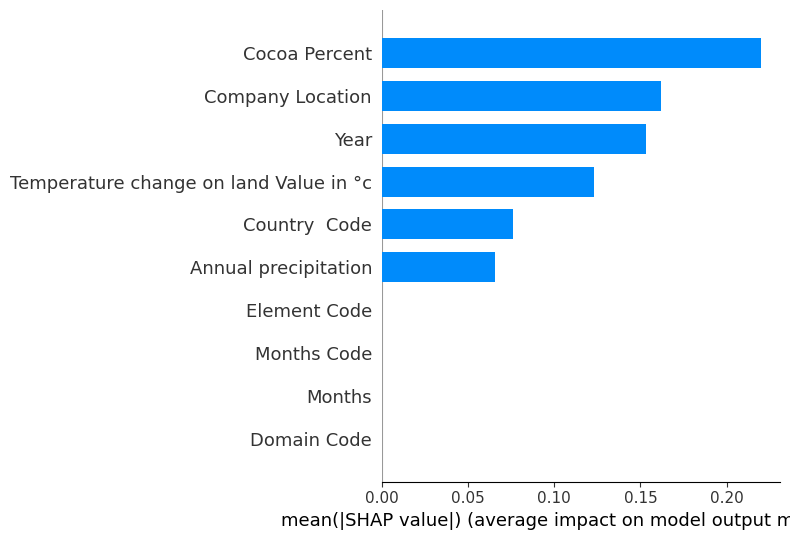

In [30]:
# STEP 1: Install Required Packages
!pip install lightgbm optuna shap xgboost --quiet

# STEP 2: Imports
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# STEP 3: Load Data
df = pd.read_csv("final_quality_dataset.csv")
target_col = "Rating (Out of 10)"
X = df.drop(columns=[target_col])
y = df[target_col]

# STEP 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 5: SHAP-Based Feature Selection (Keep Top 15)
lgb_base = lgb.LGBMRegressor()
lgb_base.fit(X_train, y_train)
explainer = shap.TreeExplainer(lgb_base)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)

# Select Top 15 Features
shap_importance = np.abs(shap_values).mean(axis=0)
top_features = pd.Series(shap_importance, index=X_train.columns).nlargest(15).index.tolist()
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# STEP 6: Optuna Tuning for LightGBM
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2),
        'num_leaves': trial.suggest_int("num_leaves", 20, 100),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        'min_child_samples': trial.suggest_int("min_child_samples", 5, 30),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train_top, y_train,
        eval_set=[(X_test_top, y_test)],
        callbacks=[lgb.early_stopping(20)]
    )
    preds = model.predict(X_test_top)
    return mean_absolute_error(y_test, preds)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

# STEP 7: Train Final LightGBM with Best Params
best_params = study.best_params
model_lgb = lgb.LGBMRegressor(**best_params)
model_lgb.fit(X_train_top, y_train)
y_pred_lgb = model_lgb.predict(X_test_top)

# STEP 8: Optional Ensembling (XGBoost + LightGBM)
model_xgb = XGBRegressor()
model_xgb.fit(X_train_top, y_train)
y_pred_xgb = model_xgb.predict(X_test_top)

# Averaging predictions
y_pred_ensemble = (y_pred_lgb + y_pred_xgb) / 2

# STEP 9: Evaluation
def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mae_score = 10 * (1 - min(mae / 10, 1))
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAE Score (out of 10): {mae_score:.2f}")
    return r2

print("\n Evaluation: LightGBM")
evaluate(y_test, y_pred_lgb)

print("\n Evaluation: Ensemble (LightGBM + XGBoost)")
evaluate(y_test, y_pred_ensemble)


**Cocoa Quality Prediction Models: R² Vs MAE Score**

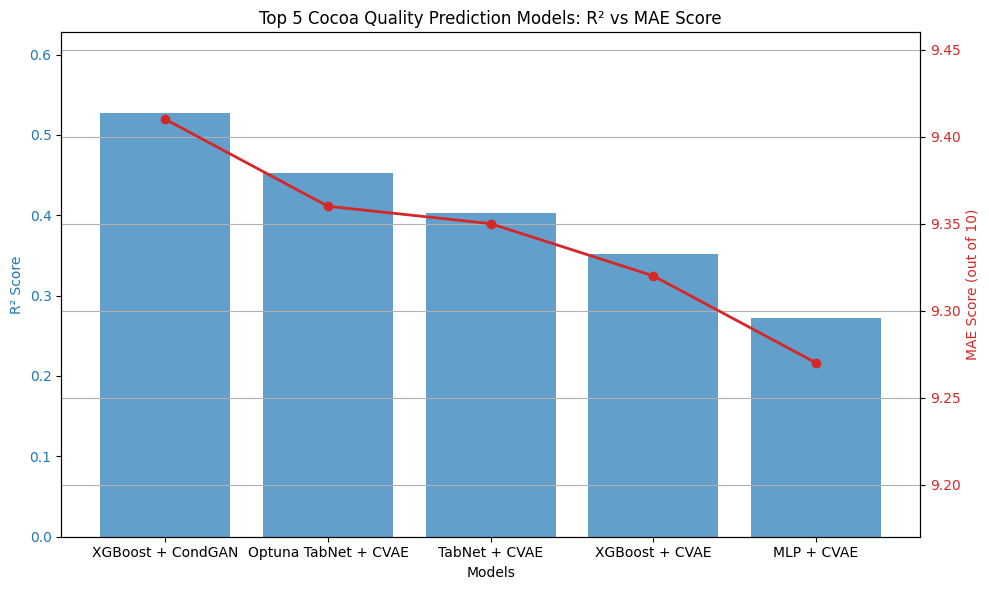

In [34]:
import matplotlib.pyplot as plt

# Top 5 models (based on your message)
models = [
    "XGBoost + CondGAN",
    "Optuna TabNet + CVAE",
    "TabNet + CVAE",
    "XGBoost + CVAE",
    "MLP + CVAE"
]

r2_scores = [0.5276, 0.4520, 0.4031, 0.3512, 0.2717]
mae_scores = [9.41, 9.36, 9.35, 9.32, 9.27]

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# R² Score - Bar Plot
color = 'tab:blue'
ax1.bar(models, r2_scores, color=color, alpha=0.7)
ax1.set_xlabel("Models")
ax1.set_ylabel("R² Score", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, max(r2_scores) + 0.1)

# MAE Score - Line Plot
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(models, mae_scores, color=color, marker='o', linewidth=2)
ax2.set_ylabel("MAE Score (out of 10)", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(min(mae_scores) - 0.1, max(mae_scores) + 0.05)

# Final layout
plt.title("Top 5 Cocoa Quality Prediction Models: R² vs MAE Score")
plt.xticks(rotation=25)
plt.grid(True)
plt.tight_layout()
plt.show()


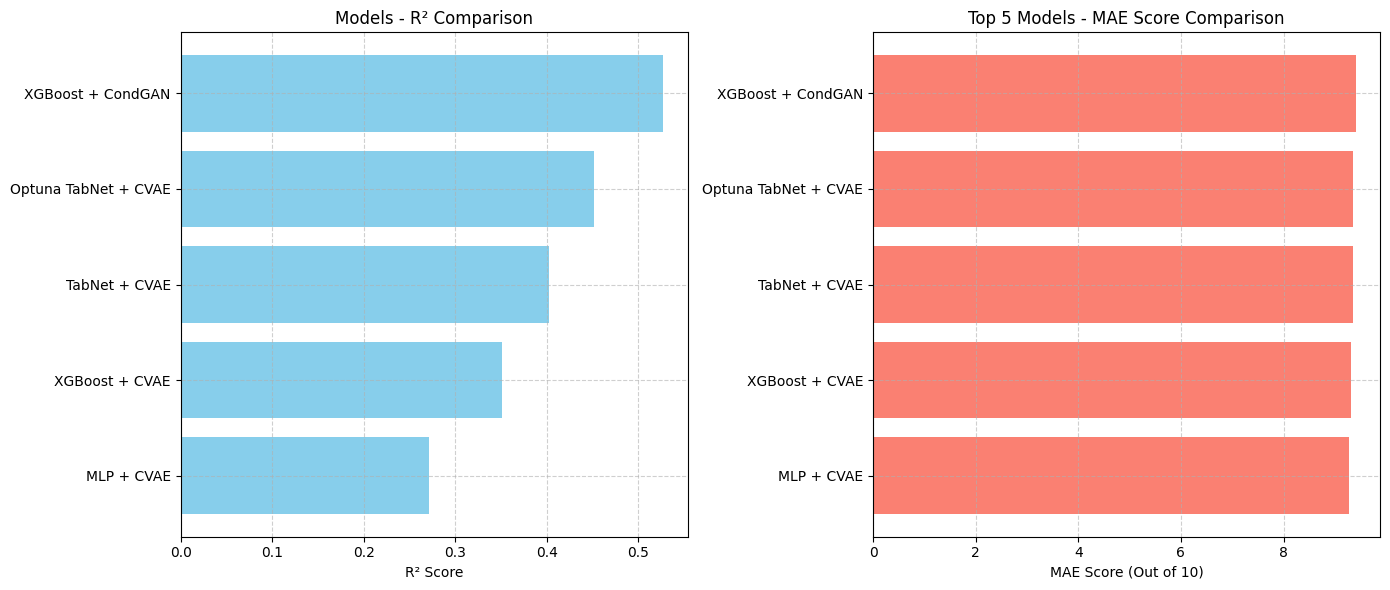

In [36]:
import matplotlib.pyplot as plt

# Top 5 models
models = [
    "XGBoost + CondGAN",
    "Optuna TabNet + CVAE",
    "TabNet + CVAE",
    "XGBoost + CVAE",
    "MLP + CVAE"
]

# Corresponding Scores
r2_scores = [0.5276, 0.4520, 0.4031, 0.3512, 0.2717]
mae_scores = [9.41, 9.36, 9.35, 9.32, 9.27]

# Side-by-side bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# R² bar chart
ax1.barh(models, r2_scores, color='skyblue')
ax1.set_xlabel("R² Score")
ax1.set_title("Models - R² Comparison")
ax1.invert_yaxis()
ax1.grid(True, linestyle='--', alpha=0.6)

# MAE bar chart
ax2.barh(models, mae_scores, color='salmon')
ax2.set_xlabel("MAE Score (Out of 10)")
ax2.set_title("Top 5 Models - MAE Score Comparison")
ax2.invert_yaxis()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
